#### Mathematical Transshipment Toy Model (7-retailers):
$$\text{min} \space E[ h(S,\tilde{D})]$$<br>
where:
<br>
$$h(S,\tilde{D}) = \text{min} \sum_{i=1}^{7} $1*e_{i} + \sum_{i=1}^{7}\sum_{j=1}^{7} $0.5* t_{ij} + \sum_{i=1}^{7} $4*r_{i} \quad \text{with} \space  t_{ij} = 0, \text{if} \space i = j$$
<br>
such that: <br>
$$f_{i} + \sum_{j = 1, j\neq i}^{7} t_{ij} + e_{i} = s_{i} \quad \forall i = 1,...,7$$
<br>
$$f_{i} + \sum_{j=1, j\neq i}^{7} t_{ji} + r_{i}  = d_{i} \quad \forall i = 1,...,7$$
<br>
$$\sum_{i=1}^{7} r_{i} + \sum_{i=1}^{7} q_{i} = \sum_{i=1}^{7} d_{i} $$
<br>
$$e_{i} + q_{i} = s_{i} \quad \forall i = 1,...,7$$

In [ ]:
#reinstall pyomo
!pip install -q pyomo

     |████████████████████████████████| 9.5MB 3.8MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 256kB 44.6MB/s 
     |████████████████████████████████| 163kB 47.5MB/s 


In [ ]:
#reinstall glpk
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

In [ ]:
import numpy as np
import random
import pyomo as pyo
from pyomo.environ import *
import pyomo.gdp as gdp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from itertools import tee
import seaborn as sns
import time
import pandas as pd

Demand Simulation

In [ ]:
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)
"""
specify the mean and variance of the normal distribution and 
choose an odd number of n points to discretize the normal distribution (default n=3).
Function will return a tuple, first component being the list of values
equally spaced by standard deviation and an array of each value's
assigned normal probability weight in the second component. Each 
probability weight is computed from the CDF using midpoint quadrature so weights sum to 1.0. 
res is an optional granularity argument to allow range of possible values to include
values that are spaced in less than 1 standard deviation increments.
"""
def discretizeNormal(mu,sigma, n,res = 1):
    wts = []
    startpt = mu - n//2*sigma
    endpt = mu + n//2*sigma
    leftvals = np.arange(startpt,mu,res*sigma)
    rightvals = np.arange(mu, endpt + res*sigma, res*sigma)
    vals = np.concatenate((leftvals,rightvals))
    zscores = (vals - mu)/sigma
    zmidpts = (zscores[1:]+zscores[:-1])/2
    for i,j in pairwise(zmidpts):
        wts.append(np.diff(norm.cdf((i,j))).item())
    wts.insert(0,norm.cdf(zmidpts[0]))
    wts.insert(len(wts),norm.cdf(zmidpts[0]))
    return (vals,wts)

def simulateDemand(n = 3):
    Retailer1_values, Retailer1_weights = discretizeNormal(100,20,n)
    d1 = np.asarray(random.choices(Retailer1_values, weights = Retailer1_weights)).item()
    Retailer2_values, Retailer2_weights = discretizeNormal(200,50,n)
    d2 = np.asarray(random.choices(Retailer2_values, weights = Retailer2_weights)).item()
    Retailer3_values, Retailer3_weights = discretizeNormal(150,30,n)
    d3 = np.asarray(random.choices(Retailer3_values, weights = Retailer3_weights)).item()
    Retailer4_values, Retailer4_weights = discretizeNormal(170,50,n)
    d4 = np.asarray(random.choices(Retailer4_values, weights = Retailer4_weights)).item()
    Retailer5_values, Retailer5_weights = discretizeNormal(180,40,n)
    d5 = np.asarray(random.choices(Retailer5_values, weights = Retailer5_weights)).item()
    Retailer6_values, Retailer6_weights = discretizeNormal(170,30,n)
    d6 = np.asarray(random.choices(Retailer6_values, weights = Retailer6_weights)).item()
    Retailer7_values, Retailer7_weights = discretizeNormal(170,50,n)
    d7 = np.asarray(random.choices(Retailer7_values, weights = Retailer7_weights)).item()
    d = [d1,d2,d3,d4,d5,d6,d7]
    #d = [d1,d2,d3,170,180,170,170]
    return d

total probability is 1.0
point demands: [ 50.   57.5  65.   72.5  80.   87.5  95.  102.5 110.  117.5 125.  132.5
 140.  147.5 155.  162.5 170.  177.5 185.  192.5 200.  207.5 215.  222.5
 230.  237.5 245.  252.5 260.  267.5 275.  282.5 290.  297.5 305.  312.5
 320.  327.5 335.  342.5 350. ]


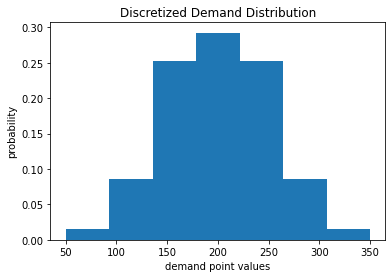

In [ ]:
#visualize discretized distribution
m=7 #number of discretized points to use
test_values, test_weights = discretizeNormal(200,50,m,res = 0.15) #input mean and std of the normal to visualize
plt.hist(x=test_values, weights=test_weights, bins = m)
plt.ylabel('probability')
plt.xlabel('demand point values')
plt.title('Discretized Demand Distribution');
print('total probability is',np.sum(test_weights))
print('point demands:', test_values)
#print(test_weights)

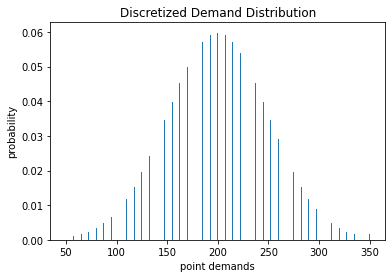

In [ ]:
plt.bar(test_values,test_weights)
plt.title('Discretized Demand Distribution')
plt.ylabel('probability')
plt.xlabel('point demands');

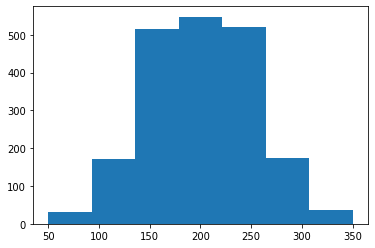

In [ ]:
#distribution verification via sampling from the discretization
xls=np.empty(0)
for j in range(0,2000):
    x = random.choices(test_values,weights=test_weights)
    xls = np.append(xls,x)
plt.hist(xls,bins=m);

SGD base model solve for step updates

In [ ]:
def solveModel(demand,svec):
    m = ConcreteModel()
    m.dual = Suffix(direction=Suffix.IMPORT)
    #primal decision variables
    m.e = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
    m.r = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
    m.t = Var(['12','13','14','15','16','17',\
               '21','23','24','25','26','27',\
               '31','32','34','35','36','37',\
               '41','42','43','45','46','47',\
               '51','52','53','54','56','57',\
               '61','62','63','64','65','67',\
               '71','72','73','74','75','76'],domain=NonNegativeReals)
    
    #q and f variables
    m.f = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)
    m.q = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

    #assign feasible s values from previous solve
    s = svec
    #assign simulated demand to model.d
    d = demand
    #Objective
    m.OBJ = Objective(expr=m.e[1]+m.e[2]+m.e[3]+m.e[4]+m.e[5]+m.e[6]+m.e[7]\
                          +0.5*(m.t['12']+m.t['13']+m.t['14']+m.t['15']+m.t['16']+m.t['17']\
                                +m.t['21']+m.t['23']+m.t['24']+m.t['25']+m.t['26']+m.t['27']\
                                +m.t['31']+m.t['32']+m.t['34']+m.t['35']+m.t['36']+m.t['37']\
                                +m.t['41']+m.t['42']+m.t['43']+m.t['45']+m.t['46']+m.t['47']\
                                +m.t['51']+m.t['52']+m.t['53']+m.t['54']+m.t['56']+m.t['57']\
                                +m.t['61']+m.t['62']+m.t['63']+m.t['64']+m.t['65']+m.t['67']\
                                +m.t['71']+m.t['72']+m.t['73']+m.t['74']+m.t['75']+m.t['76'])\
                      +4*(m.r[1]+m.r[2]+m.r[3]+m.r[4]+m.r[5]+m.r[6]+m.r[7]),sense=minimize)
    #s order-up-to constraints
    m.Constraint1 = Constraint(expr= m.f[1]+m.t['12']+m.t['13']+m.t['14']+m.t['15']+m.t['16']+m.t['17']+m.e[1]==s[0])
    m.Constraint2 = Constraint(expr= m.f[2]+m.t['21']+m.t['23']+m.t['24']+m.t['25']+m.t['26']+m.t['27']+m.e[2]==s[1])
    m.Constraint3 = Constraint(expr= m.f[3]+m.t['31']+m.t['32']+m.t['34']+m.t['35']+m.t['36']+m.t['37']+m.e[3]==s[2])
    m.Constraint4 = Constraint(expr= m.f[4]+m.t['41']+m.t['42']+m.t['43']+m.t['45']+m.t['46']+m.t['47']+m.e[4]==s[3])
    m.Constraint5 = Constraint(expr= m.f[5]+m.t['51']+m.t['52']+m.t['53']+m.t['54']+m.t['56']+m.t['57']+m.e[5]==s[4])
    m.Constraint6 = Constraint(expr= m.f[6]+m.t['61']+m.t['62']+m.t['63']+m.t['64']+m.t['65']+m.t['67']+m.e[6]==s[5])
    m.Constraint7 = Constraint(expr= m.f[7]+m.t['71']+m.t['72']+m.t['73']+m.t['74']+m.t['75']+m.t['76']+m.e[7]==s[6])

    #d demand constraints where d1,d2,d3 come from the simulated draws from discretized normal
    m.Constraint8 = Constraint(expr= m.f[1]+m.t['21']+m.t['31']+m.t['41']+m.t['51']+m.t['61']+m.t['71']+m.r[1]==d[0])
    m.Constraint9 = Constraint(expr= m.f[2]+m.t['12']+m.t['32']+m.t['42']+m.t['52']+m.t['62']+m.t['72']+m.r[2]==d[1])
    m.Constraint10 = Constraint(expr= m.f[3]+m.t['13']+m.t['23']+m.t['43']+m.t['53']+m.t['63']+m.t['73']+m.r[3]==d[2])
    m.Constraint11 = Constraint(expr= m.f[4]+m.t['14']+m.t['24']+m.t['34']+m.t['54']+m.t['64']+m.t['74']+m.r[4]==d[3])
    m.Constraint12 = Constraint(expr= m.f[5]+m.t['15']+m.t['25']+m.t['35']+m.t['45']+m.t['65']+m.t['75']+m.r[5]==d[4])
    m.Constraint13 = Constraint(expr= m.f[6]+m.t['16']+m.t['26']+m.t['36']+m.t['46']+m.t['56']+m.t['76']+m.r[6]==d[5])
    m.Constraint14 = Constraint(expr= m.f[7]+m.t['17']+m.t['27']+m.t['37']+m.t['47']+m.t['57']+m.t['67']+m.r[7]==d[6])

    #total constraints
    m.Constraint15 = Constraint(expr=m.r[1]+m.r[2]+m.r[3]+m.r[4]+m.r[5]+m.r[6]+m.r[7]\
                                  +m.q[1]+m.q[2]+m.q[3]+m.q[4]+m.q[5]+m.q[6]+m.q[7]\
                               ==d[0]+d[1]+d[2]+d[3]+d[4]+d[5]+d[6])

    #ending inventory plus replenishment constraint
    m.Constraint16 = Constraint(expr=m.e[1]+m.q[1]==s[0])
    m.Constraint17 = Constraint(expr=m.e[2]+m.q[2]==s[1])
    m.Constraint18 = Constraint(expr=m.e[3]+m.q[3]==s[2])
    m.Constraint19 = Constraint(expr=m.e[4]+m.q[4]==s[3])
    m.Constraint20 = Constraint(expr=m.e[5]+m.q[5]==s[4])
    m.Constraint21 = Constraint(expr=m.e[6]+m.q[6]==s[5])
    m.Constraint22 = Constraint(expr=m.e[7]+m.q[7]==s[6])

    opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
    #opt.solve(m,tee=True) #tee for debug
    opt.solve(m)

    return m

Get Initial Feasible S-vector from primal solve with all demands set to means

In [ ]:
m1 = ConcreteModel()
m1.dual = Suffix(direction=Suffix.IMPORT)

#primal decision variables
m1.e = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
m1.r = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
m1.t = Var(['12','13','14','15','16','17',\
            '21','23','24','25','26','27',\
            '31','32','34','35','36','37',\
            '41','42','43','45','46','47',\
            '51','52','53','54','56','57',\
            '61','62','63','64','65','67',\
            '71','72','73','74','75','76'],domain=NonNegativeReals)
#q and f variables
m1.f = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)
m1.q = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

#assign feasible s values from previous solve
m1.s = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

#assign initial demand to model.d
d = [100,200,150,170,180,170,170]

#Objective
m1.OBJ = Objective(expr=m1.e[1]+m1.e[2]+m1.e[3]+m1.e[4]+m1.e[5]+m1.e[6]+m1.e[7]\
                      +0.5*(m1.t['12']+m1.t['13']+m1.t['14']+m1.t['15']+m1.t['16']+m1.t['17']\
                            +m1.t['21']+m1.t['23']+m1.t['24']+m1.t['25']+m1.t['26']+m1.t['27']\
                            +m1.t['31']+m1.t['32']+m1.t['34']+m1.t['35']+m1.t['36']+m1.t['37']\
                            +m1.t['41']+m1.t['42']+m1.t['43']+m1.t['45']+m1.t['46']+m1.t['47']\
                            +m1.t['51']+m1.t['52']+m1.t['53']+m1.t['54']+m1.t['56']+m1.t['57']\
                            +m1.t['61']+m1.t['62']+m1.t['63']+m1.t['64']+m1.t['65']+m1.t['67']\
                            +m1.t['71']+m1.t['72']+m1.t['73']+m1.t['74']+m1.t['75']+m1.t['76'])\
                  +4*(m1.r[1]+m1.r[2]+m1.r[3]+m1.r[4]+m1.r[5]+m1.r[6]+m1.r[7]),sense=minimize)

#s order-up-to constraints
m1.Constraint1 = Constraint(expr= m1.f[1]+m1.t['12']+m1.t['13']+m1.t['14']+m1.t['15']+m1.t['16']+m1.t['17']+m1.e[1]==m1.s[1])
m1.Constraint2 = Constraint(expr= m1.f[2]+m1.t['21']+m1.t['23']+m1.t['24']+m1.t['25']+m1.t['26']+m1.t['27']+m1.e[2]==m1.s[2])
m1.Constraint3 = Constraint(expr= m1.f[3]+m1.t['31']+m1.t['32']+m1.t['34']+m1.t['35']+m1.t['36']+m1.t['37']+m1.e[3]==m1.s[3])
m1.Constraint4 = Constraint(expr= m1.f[4]+m1.t['41']+m1.t['42']+m1.t['43']+m1.t['45']+m1.t['46']+m1.t['47']+m1.e[4]==m1.s[4])
m1.Constraint5 = Constraint(expr= m1.f[5]+m1.t['51']+m1.t['52']+m1.t['53']+m1.t['54']+m1.t['56']+m1.t['57']+m1.e[5]==m1.s[5])
m1.Constraint6 = Constraint(expr= m1.f[6]+m1.t['61']+m1.t['62']+m1.t['63']+m1.t['64']+m1.t['65']+m1.t['67']+m1.e[6]==m1.s[6])
m1.Constraint7 = Constraint(expr= m1.f[7]+m1.t['71']+m1.t['72']+m1.t['73']+m1.t['74']+m1.t['75']+m1.t['76']+m1.e[7]==m1.s[7])

#d demand constraints where d1,d2,d3 come from the simulated draws from discretized normal
m1.Constraint8 = Constraint(expr= m1.f[1]+m1.t['21']+m1.t['31']+m1.t['41']+m1.t['51']+m1.t['61']+m1.t['71']+m1.r[1]==d[0])
m1.Constraint9 = Constraint(expr= m1.f[2]+m1.t['12']+m1.t['32']+m1.t['42']+m1.t['52']+m1.t['62']+m1.t['72']+m1.r[2]==d[1])
m1.Constraint10= Constraint(expr= m1.f[3]+m1.t['13']+m1.t['23']+m1.t['43']+m1.t['53']+m1.t['63']+m1.t['73']+m1.r[3]==d[2])
m1.Constraint11= Constraint(expr= m1.f[4]+m1.t['14']+m1.t['24']+m1.t['34']+m1.t['54']+m1.t['64']+m1.t['74']+m1.r[4]==d[3])
m1.Constraint12= Constraint(expr= m1.f[5]+m1.t['15']+m1.t['25']+m1.t['35']+m1.t['45']+m1.t['65']+m1.t['75']+m1.r[5]==d[4])
m1.Constraint13= Constraint(expr= m1.f[6]+m1.t['16']+m1.t['26']+m1.t['36']+m1.t['46']+m1.t['56']+m1.t['76']+m1.r[6]==d[5])
m1.Constraint14= Constraint(expr= m1.f[7]+m1.t['17']+m1.t['27']+m1.t['37']+m1.t['47']+m1.t['57']+m1.t['67']+m1.r[7]==d[6])

#total constraints
m1.Constraint15 = Constraint(expr=m1.r[1]+m1.r[2]+m1.r[3]+m1.r[4]+m1.r[5]+m1.r[6]+m1.r[7]\
                              +m1.q[1]+m1.q[2]+m1.q[3]+m1.q[4]+m1.q[5]+m1.q[6]+m1.q[7]\
                            ==d[0]+d[1]+d[2]+d[3]+d[4]+d[5]+d[6])

#ending inventory plus replenishment constraint
m1.Constraint16 = Constraint(expr=m1.e[1]+m1.q[1]==m1.s[1])
m1.Constraint17 = Constraint(expr=m1.e[2]+m1.q[2]==m1.s[2])
m1.Constraint18 = Constraint(expr=m1.e[3]+m1.q[3]==m1.s[3])
m1.Constraint19 = Constraint(expr=m1.e[4]+m1.q[4]==m1.s[4])
m1.Constraint20 = Constraint(expr=m1.e[5]+m1.q[5]==m1.s[5])
m1.Constraint21 = Constraint(expr=m1.e[6]+m1.q[6]==m1.s[6])
m1.Constraint22 = Constraint(expr=m1.e[7]+m1.q[7]==m1.s[7])

opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
opt.solve(m1)
#opt.solve(model,tee=True,keepfiles=False) #tee for debug
m1.s.display()

s : Size=7, Index=s_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      1 :     0 : 100.0 :  None : False : False : NonNegativeReals
      2 :     0 : 200.0 :  None : False : False : NonNegativeReals
      3 :     0 : 150.0 :  None : False : False : NonNegativeReals
      4 :     0 : 170.0 :  None : False : False : NonNegativeReals
      5 :     0 : 180.0 :  None : False : False : NonNegativeReals
      6 :     0 : 170.0 :  None : False : False : NonNegativeReals
      7 :     0 : 170.0 :  None : False : False : NonNegativeReals


In [ ]:
s_feas =[]
for i in m1.s.extract_values():
    s_feas.append(m1.s.extract_values()[i])
s_feas

[100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]

In [ ]:
m1.s.extract_values()

{1: 100.0, 2: 200.0, 3: 150.0, 4: 170.0, 5: 180.0, 6: 170.0, 7: 170.0}

Stochastic Gradient Descent

In [ ]:
demand = simulateDemand()
print('example demand vector: ',demand)

s_old = s_feas
print('initial s-vector: ', s_old)

example demand vector:  [100, 150, 150, 220, 140, 140, 170]
initial s-vector:  [100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]


In [ ]:
30%20

10

In [ ]:
#SGD with for loop
s_old = s_feas
subglist, steplist, subgsteps, subgnorms, dlist, batchdem, s_list, objlist = [],[],[],[],[],[],[],[]
runningObj = []
alpha_k = 1.0 #stepsize constant
steps = 200
batchsize = 5 #number of solves per step
steptimes = []
valObjs = []
start = time.time()
for j in range(0,steps): #try error tolerance subgradnorm < 0.01 while loop instead of steps
    stepstart = time.time()
    for i in range(0,batchsize):
        #simulate a demand vector
        demand = simulateDemand(3)
        #solve the 2nd stage minimization problem given demand and last order-up-to vector
        a = solveModel(demand,s_old)
        #compute subgradient from duals
        subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
               a.dual[a.Constraint2] + a.dual[a.Constraint17],\
               a.dual[a.Constraint3] + a.dual[a.Constraint18],\
               a.dual[a.Constraint4] + a.dual[a.Constraint19],\
               a.dual[a.Constraint5] + a.dual[a.Constraint20],\
               a.dual[a.Constraint6] + a.dual[a.Constraint21],\
               a.dual[a.Constraint7] + a.dual[a.Constraint22]])
        objlist.append(a.OBJ())
        subglist.append(subgrad)
        batchdem.append(demand)
    batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
    subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
    objavg = np.mean(objlist)
    runningObj.append(objavg)
   
    #projection step
    s_cand = s_old - (alpha_k/np.sqrt(j+1))*subgstep
    for i in range(0,len(s_cand)):
      if s_cand[i] < 0:
        subgstep[i] = 0
      else:
        subgstep = subgstep
    
    #update s-vector
    s_old = s_old - (alpha_k/np.sqrt(j+1))*subgstep #divide by current step or sqrt of current step
    #try different divisors or different step size constants

    #validate on every step
    if j%1 == 0:
      objVals = []
      s_opt = s_old
      tests = 101
      for k in range(0,tests):
        #simulate a demand vector
        demtest = simulateDemand(3)
        #solve the 2nd stage minimization problem given demand and last order-up-to vector
        b = solveModel(demtest, s_opt)
        #store the 25 test objVals for this decision
        objVals.append(b.OBJ())
      #store list of list of objVals
      valObjs.append(objVals) 
    #objValMeans.append(objMeans)


    stepstop = time.time()
    stepspeed = stepstop - stepstart
    #record history
    err = np.linalg.norm(subgstep)
    subgsteps.append(subgstep)
    subgnorms.append(err)
    dlist.append(batchgdem)
    s_list.append(s_old)
    steplist.append(j+1)
    steptimes.append(stepspeed)
end =  time.time()
print('total runtime:', end - start)

total runtime: 738.8041279315948


In [ ]:
#Warning Very Slow
#SGD with while loop (gradient convergence criterion using tolerance level)
'''
s_old = s_feas
subglist,steplist,subgsteps,subgnorms,dlist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
runningObj = []
alpha_k = 1.0 #stepsize constant
batchsize= 5 #number of solves per step
errtol = 0.1 #error tolerance for convergence. #note errtol of 0.1 or lower results in ~10-15 minute runtime
j = 0
while True:
    for i in range(0,batchsize):
        #simulate a demand vector
        demand = simulateDemand()
        #solve the 2nd stage minimization problem given demand and last order-up-to vector
        a = solveModel(demand,s_old)
        #compute subgradient from duals
        subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
               a.dual[a.Constraint2] + a.dual[a.Constraint17],\
               a.dual[a.Constraint3] + a.dual[a.Constraint18],\
               a.dual[a.Constraint4] + a.dual[a.Constraint19],\
               a.dual[a.Constraint5] + a.dual[a.Constraint20],\
               a.dual[a.Constraint6] + a.dual[a.Constraint21],\
               a.dual[a.Constraint7] + a.dual[a.Constraint22]])
        objlist.append(a.OBJ())
        subglist.append(subgrad)
        batchdem.append(demand)
    batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
    subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
    objavg = np.mean(objlist)
    runningObj.append(objavg)
    
    #projection step
    s_cand = s_old - (alpha_k/np.sqrt(j+1))*subgstep
    for i in range(0,len(s_cand)):
      if s_cand[i] < 0:
        subgstep[i] = 0
      else:
        subgstep = subgstep
    
    #update s-vector
    s_old = s_old - (alpha_k/np.sqrt(j+1))*subgstep #divide by current step or sqrt of current step
    #try different divisors or different step size constants
    
    #record history
    err = np.linalg.norm(subgstep)
    subgsteps.append(subgstep)
    subgnorms.append(err)
    dlist.append(batchgdem)
    s_list.append(s_old)
    steplist.append(j+1)
    j +=1 #increment step number
    if err < errtol: #termination condition
      break
'''

Benders_data processing

In [ ]:
#load bender's data for comparative graphs
from google.colab import files
load_benders_data = files.upload()

Saving Benders_data.csv to Benders_data.csv


In [ ]:
bd = pd.read_csv('Benders_data.csv')
#bdata.rename(columns={'Unnamed: 0':'step','S-vectors':'svectors'},inplace=True)
bd.rename(columns={'Unnamed: 0':'step','Objective Value':'ObjVal','subgradient norm':'subgNorm','Time taken':'time'},inplace=True)
bd.head()

,step,ObjVal,Delta,subgNorm,time,Upperbound,Lowerbound,s1,s2,s3,s4,s5,s6,s7
0,0,201.21238,201.21238,348.769623,65.393189,201.21238,0.0,0.0,0.000000,1227.768458,0.0,0.000000,0.000000,0.000000
1,1,201.21238,201.21238,205.665991,65.558977,201.21238,0.0,0.0,670.990625,556.777833,0.0,0.000000,0.000000,0.000000
2,2,201.21238,201.21238,206.661559,65.655460,201.21238,0.0,0.0,109.267558,556.777833,0.0,561.723067,0.000000,0.000000
3,3,201.21238,201.21238,207.755265,65.162348,201.21238,0.0,0.0,681.773764,0.000000,0.0,361.552014,0.000000,205.656971
4,4,201.21238,201.21238,178.995112,65.501413,201.21238,0.0,0.0,502.443395,185.798506,0.0,263.577057,305.887958,0.000000


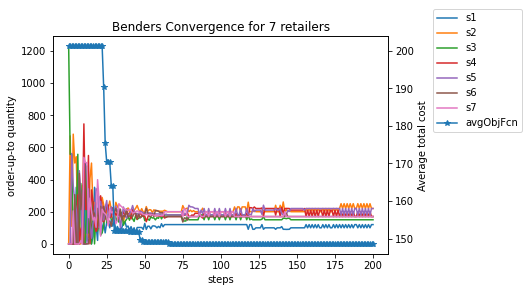

In [ ]:
fig,ax = plt.subplots()
ax.plot(bd.step,bd.s1,label='s1')#,marker='.')
ax.plot(bd.step,bd.s2,label='s2')# ,marker='v')
ax.plot(bd.step,bd.s3,label='s3')#,marker='^')
ax.plot(bd.step,bd.s4,label='s4')#,marker='s')
ax.plot(bd.step,bd.s5,label='s5')#,marker='p')
ax.plot(bd.step,bd.s6,label='s6')#,marker='P')
ax.plot(bd.step,bd.s7,label='s7')#,marker='*')
ax.set_xlabel('steps')
ax.set_ylabel('order-up-to quantity')
ax2 = ax.twinx()
ax2.plot(bd.step,bd.ObjVal,label='avgObjFcn',marker='*')
ax2.set_ylabel('Average total cost')
ax.set_title('Benders Convergence for 7 retailers');
fig.legend(bbox_to_anchor=(1.22,1));

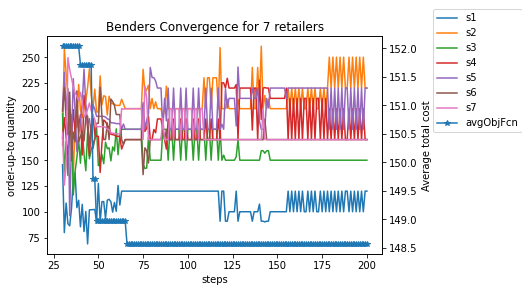

In [ ]:
#Bender convergence for 7 retailers zoomed in, after initial bounds 
bgn = 30
fig,ax = plt.subplots()
ax.plot(bd.step.iloc[bgn:],bd.s1.iloc[bgn:],label='s1')#,marker='.')
ax.plot(bd.step.iloc[bgn:],bd.s2.iloc[bgn:],label='s2')# ,marker='v')
ax.plot(bd.step.iloc[bgn:],bd.s3.iloc[bgn:],label='s3')#,marker='^')
ax.plot(bd.step.iloc[bgn:],bd.s4.iloc[bgn:],label='s4')#,marker='s')
ax.plot(bd.step.iloc[bgn:],bd.s5.iloc[bgn:],label='s5')#,marker='p')
ax.plot(bd.step.iloc[bgn:],bd.s6.iloc[bgn:],label='s6')#,marker='P')
ax.plot(bd.step.iloc[bgn:],bd.s7.iloc[bgn:],label='s7')#,marker='*')
ax.set_xlabel('steps')
ax.set_ylabel('order-up-to quantity')
ax2 = ax.twinx()
ax2.plot(bd.step.iloc[bgn:],bd.ObjVal.iloc[bgn:],label='avgObjFcn',marker='*')
ax2.set_ylabel('Average total cost')
ax.set_title('Benders Convergence for 7 retailers');
fig.legend(bbox_to_anchor=(1.22,1));

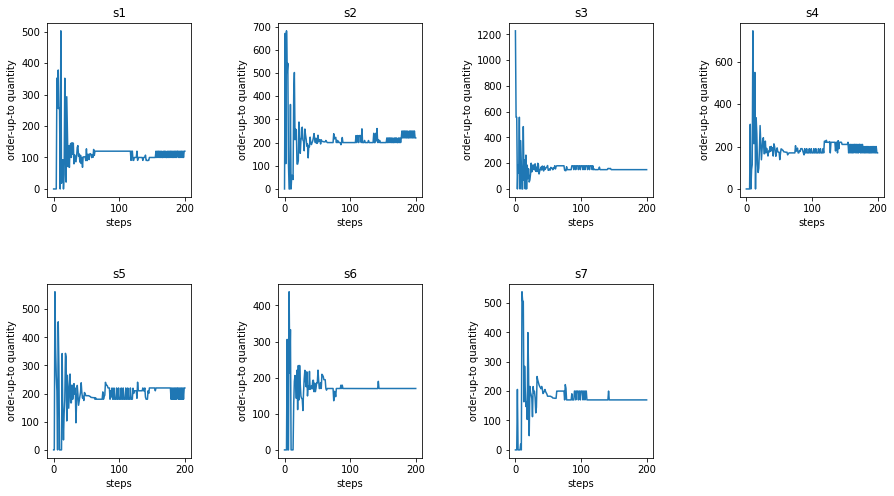

In [ ]:
figure, axs = plt.subplots(2,4,figsize=(15,8))
plt.subplots_adjust(hspace=0.5,wspace=0.6)
axs[0,0].plot(bd.step,bd.s1)
axs[0,0].set_title('s1')
axs[0,0].set_ylabel('order-up-to quantity')
axs[0,0].set_xlabel('steps')
#axs[0,0].legend(loc='lower right')
axs[0,1].plot(bd.step,bd.s2)
axs[0,1].set_title('s2')
axs[0,1].set_ylabel('order-up-to quantity')
axs[0,1].set_xlabel('steps')
#axs[0,1].legend(loc='lower right')
axs[0,2].plot(bd.step,bd.s3)
axs[0,2].set_title('s3')
axs[0,2].set_ylabel('order-up-to quantity')
axs[0,2].set_xlabel('steps')
#axs[0,2].legend(loc='lower right')
axs[0,3].plot(bd.step,bd.s4)
axs[0,3].set_title('s4')
axs[0,3].set_ylabel('order-up-to quantity')
axs[0,3].set_xlabel('steps')
axs[1,0].plot(bd.step,bd.s5)
axs[1,0].set_title('s5')
axs[1,0].set_ylabel('order-up-to quantity')
axs[1,0].set_xlabel('steps')
axs[1,1].plot(bd.step,bd.s6)
axs[1,1].set_title('s6')
axs[1,1].set_ylabel('order-up-to quantity')
axs[1,1].set_xlabel('steps')
axs[1,2].plot(bd.step,bd.s7)
axs[1,2].set_title('s7')
axs[1,2].set_ylabel('order-up-to quantity')
axs[1,2].set_xlabel('steps')
axs[1,3].axis('off');#plot(steplist,d_tot,s_tot)
#axs[1,3].set_title('total d vs. total s');

In [ ]:
print('final s1', bd.s1.iloc[-1])
print('final s2', bd.s2.iloc[-1])
print('final s3', bd.s3.iloc[-1])
print('final s4', bd.s4.iloc[-1])
print('final s5', bd.s5.iloc[-1])
print('final s6', bd.s6.iloc[-1])
print('final s7', bd.s7.iloc[-1])
print('final objval', bd.ObjVal.iloc[-1])

final s1 120.0
final s2 220.0
final s3 150.0
final s4 170.0
final s5 220.0
final s6 170.0
final s7 170.0
final objval 148.5720221


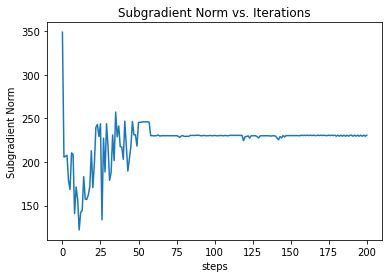

In [ ]:
plt.plot(bd.step,bd.subgNorm)
plt.ylabel('Subgradient Norm')
plt.xlabel('steps')
plt.title('Subgradient Norm vs. Iterations');

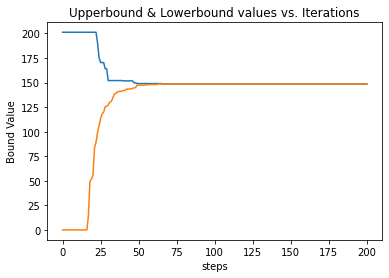

In [ ]:
plt.plot(bd.step, bd.Upperbound,bd.Lowerbound)
plt.ylabel('Bound Value')
plt.xlabel('steps')
plt.title('Upperbound & Lowerbound values vs. Iterations');

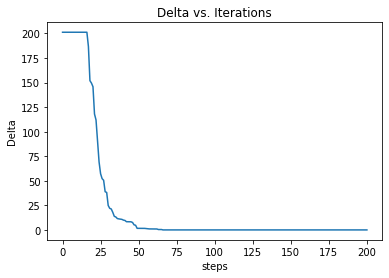

In [ ]:
plt.plot(bd.step, bd.Delta)
plt.xlabel('steps')
plt.ylabel('Delta')
plt.title('Delta vs. Iterations');

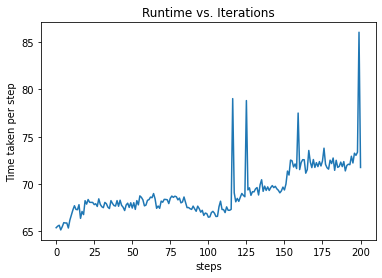

In [ ]:
plt.plot(bd.step,bd.time)
plt.xlabel('steps')
plt.ylabel('Time taken per step')
plt.title('Runtime vs. Iterations');

In [ ]:
bd.time.sum()

13906.41663029

#### Comparison Graphs

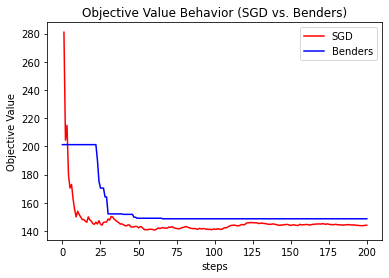

In [ ]:
plt.plot(bd.step.iloc[1:],runningObj, label='SGD',color='r')
plt.plot(bd.step, bd.ObjVal,label='Benders',color='b')
plt.xlabel('steps')
plt.ylabel('Objective Value')
plt.legend()
plt.title('Objective Value Behavior (SGD vs. Benders)');

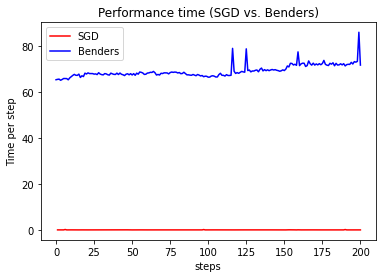

In [ ]:
plt.plot(bd.step.iloc[1:],steptimes, label='SGD',color='r')
plt.plot(bd.step, bd.time,label='Benders',color='b')
plt.xlabel('steps')
plt.ylabel('Time per step')
plt.legend()
plt.title('Performance time (SGD vs. Benders)');

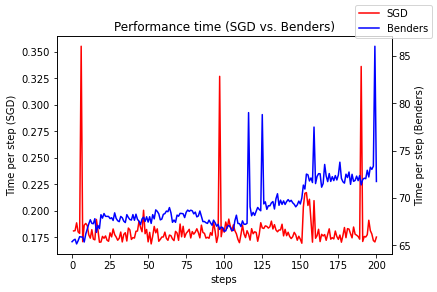

In [ ]:
fig,ax = plt.subplots()
ax.plot(bd.step.iloc[1:], steptimes, label='SGD',color='r')# ,marker='v')
ax.set_xlabel('steps')
ax.set_ylabel('Time per step (SGD)')
ax2 = ax.twinx()
ax2.plot(bd.step,bd.time,label='Benders',color='b')
ax2.set_ylabel('Time per step (Benders)')
ax.set_title('Performance time (SGD vs. Benders)');
fig.legend();

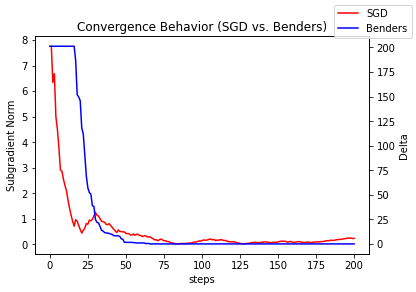

In [ ]:
fig,ax = plt.subplots()
ax.plot(bd.step.iloc[1:], subgnorms, label='SGD',color='r')# ,marker='v')
ax.set_xlabel('steps')
ax.set_ylabel('Subgradient Norm')
ax2 = ax.twinx()
ax2.plot(bd.step,bd.Delta,label='Benders',color='b')
ax2.set_ylabel('Delta')
ax.set_title('Convergence Behavior (SGD vs. Benders)');
fig.legend();

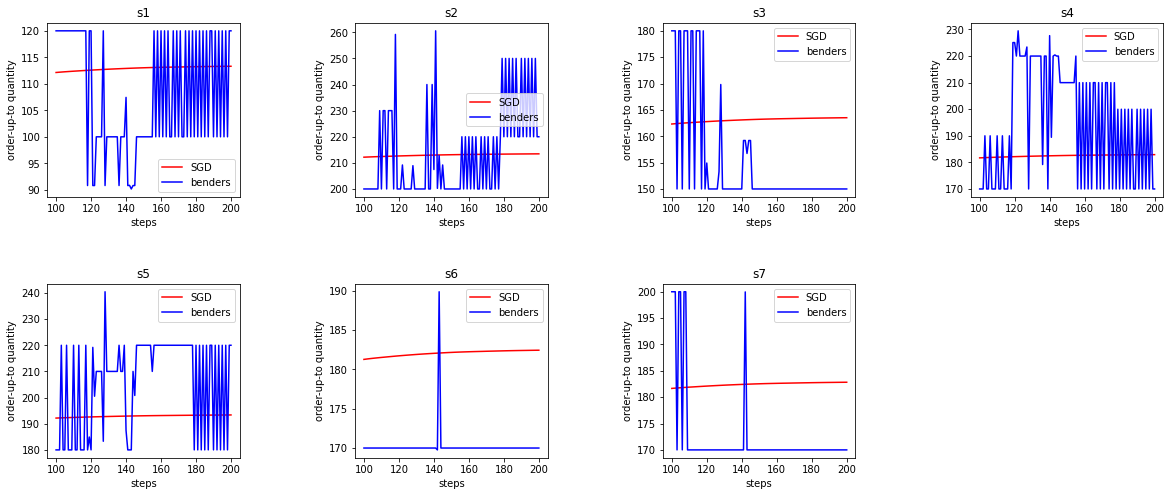

In [ ]:
bgn = 100 #minimum is 1
figure, axs = plt.subplots(2,4,figsize=(20,8))
plt.subplots_adjust(hspace=0.5,wspace=0.6)
axs[0,0].plot(bd.step.iloc[bgn:],s1[bgn-1:],label='SGD',color='r')
axs[0,0].plot(bd.step.iloc[bgn:],bd.s1.iloc[bgn:],label='benders',color='b')
axs[0,0].legend()
axs[0,0].set_title('s1')
axs[0,0].set_ylabel('order-up-to quantity')
axs[0,0].set_xlabel('steps')
#axs[0,0].legend(loc='lower right')
axs[0,1].plot(bd.step.iloc[bgn:],s2[bgn-1:],label='SGD',color='r')
axs[0,1].plot(bd.step.iloc[bgn:],bd.s2.iloc[bgn:],label='benders',color='b')
axs[0,1].legend()
axs[0,1].set_title('s2')
axs[0,1].set_ylabel('order-up-to quantity')
axs[0,1].set_xlabel('steps')
#axs[0,1].legend(loc='lower right')
axs[0,2].plot(bd.step.iloc[bgn:],s3[bgn-1:],label='SGD',color='r')
axs[0,2].plot(bd.step.iloc[bgn:],bd.s3.iloc[bgn:],label='benders',color='b')
axs[0,2].legend()
axs[0,2].set_title('s3')
axs[0,2].set_ylabel('order-up-to quantity')
axs[0,2].set_xlabel('steps')
#axs[0,2].legend(loc='lower right')
axs[0,3].plot(bd.step.iloc[bgn:],s4[bgn-1:],label='SGD',color='r')
axs[0,3].plot(bd.step.iloc[bgn:],bd.s4.iloc[bgn:],label='benders',color='b')
axs[0,3].legend()
axs[0,3].set_title('s4')
axs[0,3].set_ylabel('order-up-to quantity')
axs[0,3].set_xlabel('steps')
#####
axs[1,0].plot(bd.step.iloc[bgn:],s5[bgn-1:],label='SGD',color='r')
axs[1,0].plot(bd.step.iloc[bgn:],bd.s5.iloc[bgn:],label='benders',color='b')
axs[1,0].legend()
axs[1,0].set_title('s5')
axs[1,0].set_ylabel('order-up-to quantity')
axs[1,0].set_xlabel('steps')
###
axs[1,1].plot(bd.step.iloc[bgn:],s6[bgn-1:],label='SGD',color='r')
axs[1,1].plot(bd.step.iloc[bgn:],bd.s6.iloc[bgn:],label='benders',color='b')
axs[1,1].set_title('s6')
axs[1,1].set_ylabel('order-up-to quantity')
axs[1,1].set_xlabel('steps')
axs[1,1].legend()
####
axs[1,2].plot(bd.step.iloc[bgn:],s7[bgn-1:],label='SGD',color='r')
axs[1,2].plot(bd.step.iloc[bgn:],bd.s7.iloc[bgn:],label='benders',color='b')
axs[1,2].legend()
axs[1,2].set_title('s7')
axs[1,2].set_ylabel('order-up-to quantity')
axs[1,2].set_xlabel('steps')
axs[1,3].axis('off');

SGD Performance & Behavior Evaluation

final subgradient norm:  0.1259851181687742
minimum subgradient is:  0.1259851181687742
min subgradient occurs at step 199


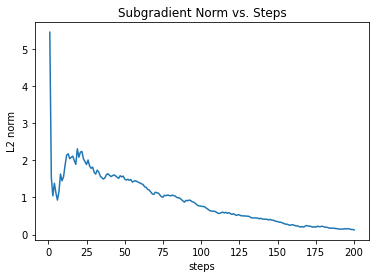

In [ ]:
#Use plot to verify the SGD Convergence by checking that L2 Norm -> 0.
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final subgradient norm:  0.07507496253745319
minimum subgradient is:  0.07256106247932524
min subgradient occurs at step 192


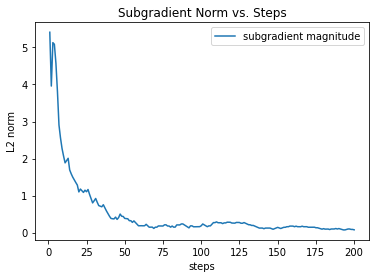

In [ ]:
#newplots
plt.plot(steplist,subgnorms,label='subgradient magnitude')
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
plt.legend()
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  148.3232570029283


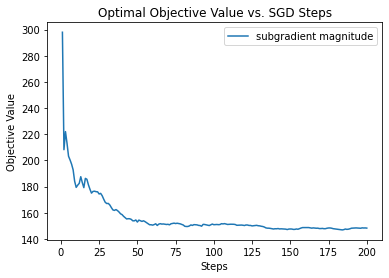

In [ ]:
plt.plot(steplist,runningObj)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', runningObj[-1])

In [ ]:
valObjs = np.asarray(valObjs)

In [ ]:
valmus = np.mean(valObjs,axis=1)
#valse = np.std(valObjs,axis=1)/np.sqrt(25)
valse = np.std(valObjs,axis=1)/np.sqrt(100)
lbnd = valmus -1.96*valse 
ubnd = valmus +1.96*valse

In [ ]:
#bounds = np.concatenate((lbnd[:,np.newaxis],ubnd[:,np.newaxis]),axis=1)
errs = np.concatenate((1.96*valse[:,np.newaxis],1.96*valse[:,np.newaxis]),axis=1)

In [ ]:
#bounds.T.shape
#errs.T

final objective value:  148.3232570029283


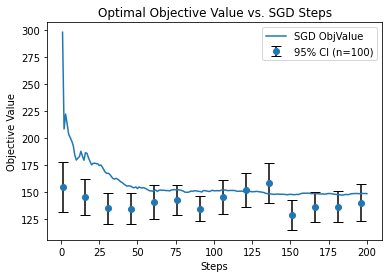

In [ ]:
#new plot
plt.plot(steplist,runningObj,label='SGD ObjValue')#,color='b')
#plt.errorbar(steplist,runningObj,yerr=ubnd-lbnd, errorevery=15, markevery=15,ecolor='k',fmt= '^',capsize=5)
plt.errorbar(steplist,valmus,yerr=errs.T, errorevery=15, markevery=15,ecolor='k',capsize=5,fmt='o',label='95% CI (n=100)')#fmt= '^',capsize=5)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.legend()
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', runningObj[-1])

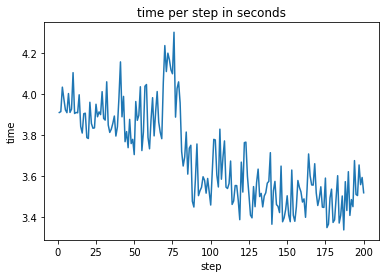

total runtime: 738.8041279315948


In [ ]:
#plot of time per step for fixed batchsizes =5
plt.plot(steplist,steptimes)
plt.title('time per step in seconds')
plt.xlabel('step')
plt.ylabel('time')
plt.show();
print('total runtime:',end - start)

In [ ]:
print('Lower Bound?:',np.mean(runningObj))
print('last Objective Value:', runningObj[-1])

Lower Bound?: 143.10335199245227
last Objective Value: 140.74183524363892


In [ ]:
print('minimum subgradient: ',np.min(subgnorms))
print('step of min subgradient: ', np.argmin(subgnorms))

minimum subgradient:  0.017720045146669347
step of min subgradient:  199


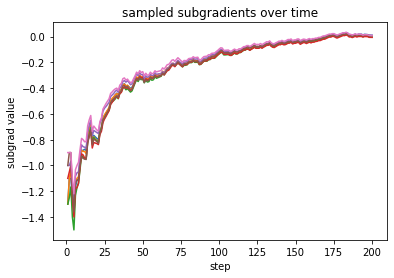

In [ ]:
plt.plot(steplist,subgsteps)
plt.title('sampled subgradients over time')
plt.ylabel('subgrad value')
plt.xlabel('step');

In [ ]:
#means of demand vector
print('true means of demand: ',[100.,200.,150.,170.0, 180.0, 170.0, 170.0])
print('running average demand: \n', np.mean(dlist,axis=0).tolist())
print('last demand: \n', dlist[-1].tolist())
print('last s-vector: \n', s_list[-1].tolist())
print('last avg subgradient: \n', subgsteps[-1].tolist())

true means of demand:  [100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]
running average demand: 
 [99.4459524513735, 202.29682952903147, 149.579132973668, 169.6473125413869, 180.86350622191253, 170.03878815023273, 170.55680916128586]
last demand: 
 [99.42, 201.9, 149.94, 170.65, 180.92, 169.43, 170.25]
last s-vector: 
 [111.7843117417696, 212.43780000033644, 161.73735853213228, 181.6146527140312, 191.77314759728662, 181.7699207033292, 181.53809135725604]
last avg subgradient: 
 [-0.018, -0.036, -0.024, -0.035, -0.039, -0.0145, -0.022]


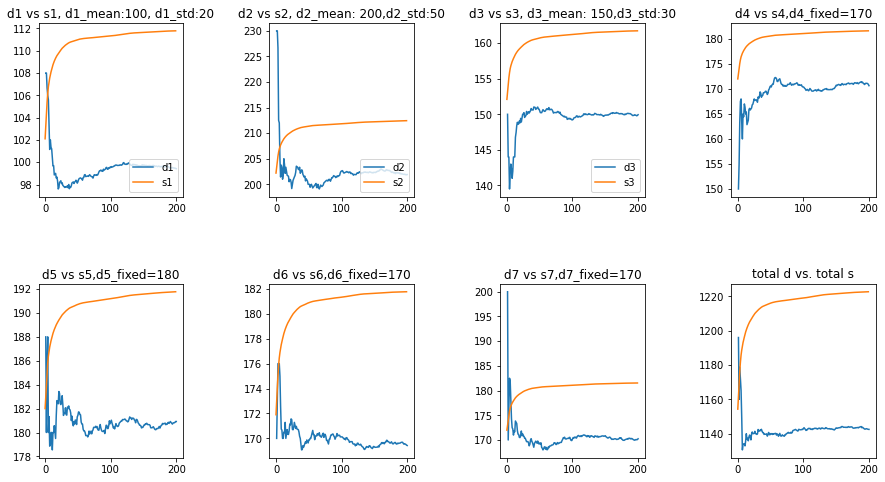

In [ ]:
s1,d1,s2,d2,s3,d3,s4,d4,s5,d5,s6,d6,s7,d7 = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(0,len(s_list)):
    s1.append(s_list[i][0])
    d1.append(dlist[i][0])
    s2.append(s_list[i][1])
    d2.append(dlist[i][1])
    s3.append(s_list[i][2])
    d3.append(dlist[i][2])
    s4.append(s_list[i][3])
    d4.append(dlist[i][3])
    s5.append(s_list[i][4])
    d5.append(dlist[i][4])
    s6.append(s_list[i][5])
    d6.append(dlist[i][5])
    s7.append(s_list[i][6])
    d7.append(dlist[i][6])
s_tot,d_tot =[],[]
for j in range(0,len(s_list)):
  s_tot.append(np.sum(s_list[j]))
  d_tot.append(np.sum(dlist[j]))
figure, axs = plt.subplots(2,4,figsize=(15,8))
plt.subplots_adjust(hspace=0.5,wspace=0.6)
axs[0,0].plot(steplist,d1,s1)
axs[0,0].set_title('d1 vs s1, d1_mean:100, d1_std:20')
axs[0,0].legend(['d1','s1'],loc='lower right')
axs[0,1].plot(steplist,d2,s2)
axs[0,1].set_title('d2 vs s2, d2_mean: 200,d2_std:50')
axs[0,1].legend(['d2','s2'],loc='lower right')
axs[0,2].plot(steplist,d3,s3)
axs[0,2].set_title('d3 vs s3, d3_mean: 150,d3_std:30')
axs[0,2].legend(['d3','s3'],loc='lower right')
axs[0,3].plot(steplist,d4,s4)
axs[0,3].set_title('d4 vs s4,d4_fixed=170')
axs[1,0].plot(steplist,d5,s5)
axs[1,0].set_title('d5 vs s5,d5_fixed=180')
axs[1,1].plot(steplist,d6,s6)
axs[1,1].set_title('d6 vs s6,d6_fixed=170')
axs[1,2].plot(steplist,d7,s7)
axs[1,2].set_title('d7 vs s7,d7_fixed=170');
axs[1,3].plot(steplist,d_tot,s_tot)
axs[1,3].set_title('total d vs. total s');

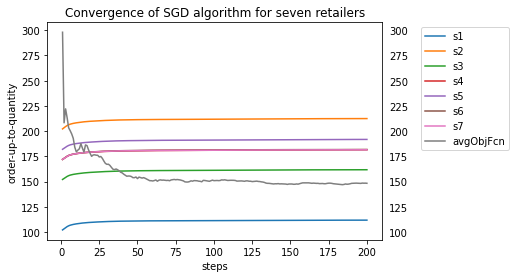

In [ ]:
plt.plot(steplist,s1,label='s1')
plt.plot(steplist,s2,label='s2')
plt.plot(steplist,s3,label='s3')
plt.plot(steplist,s4,label='s4')
plt.plot(steplist,s5,label='s5')
plt.plot(steplist,s6,label='s6')
plt.plot(steplist,s7,label='s7')
plt.plot(steplist,runningObj, label='avgObjFcn')
plt.xlabel('steps')
plt.tick_params(axis='y',which='both',labelleft='on',labelright='on')
plt.ylabel('order-up-to-quantity')
plt.legend(bbox_to_anchor=(1.10,1))
plt.title('Convergence of SGD algorithm for seven retailers');

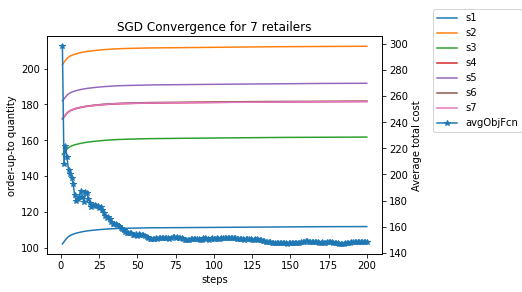

In [ ]:
fig,ax = plt.subplots()
ax.plot(steplist,s1,label='s1')#,marker='.')
ax.plot(steplist,s2,label='s2')# ,marker='v')
ax.plot(steplist,s3,label='s3')#,marker='^')
ax.plot(steplist,s4,label='s4')#,marker='s')
ax.plot(steplist,s5,label='s5')#,marker='p')
ax.plot(steplist,s6,label='s6')#,marker='P')
ax.plot(steplist,s7,label='s7')#,marker='*')
ax.set_xlabel('steps')
ax.set_ylabel('order-up-to quantity')
ax2 = ax.twinx()
ax2.plot(steplist,runningObj,label='avgObjFcn',marker='*')
ax2.set_ylabel('Average total cost')
ax.set_title('SGD Convergence for 7 retailers');
fig.legend(bbox_to_anchor=(1.22,1));

Computational Experiments, Replications, Bounds, and Solution Evaluation.

In [ ]:
#Lower Bounds:
#To Compute Lower Bound, run the entire SGD algorithm to completion for several full replications
#Collect the final objective value of each full SGD run. (Note: this can take several minutes)
#The average of the final objective value across all replications will be the lower bound point estimate.
#The Standard Deviation across all replications is the margin of error on the Lower Bound.

#SGD with replicants
NumReps,repObj=[],[]
muObj,seObj = [],[]
replications = 20 #use more replications to get convergence
for k in range(0,replications):
  s_old = s_feas
  subglist,steplist,subgsteps,subgnorms,dlist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []
  alpha_k = 1.0 #stepsize constant
  steps = 200
  batchsize= 5 #number of solves per step

  for j in range(0,steps): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          demand = simulateDemand()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_old)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)
      
      #projection step
      s_cand = s_old - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep
      
      #update s-vector
      s_old = s_old - (alpha_k/np.sqrt(j+1))*subgstep 
      #record history
      err = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err)
      dlist.append(batchgdem)
      s_list.append(s_old)
      steplist.append(j+1)
#collect replication datapoints for lower bound computation
  NumReps.append(k+1)
  muObj.append(np.mean(runningObj))
  seObj.append(np.std(runningObj))
  repObj.append(runningObj[-1])

In [ ]:
seObj[:5]

[6.681862016732863,
 18.448407368861826,
 10.051877909991374,
 11.54905745209984,
 9.560143058400197]

In [ ]:
seObjCopy = seObj.copy()

In [ ]:
seObjCopy = np.asarray(seObjCopy)

In [ ]:
errbar = np.concatenate((1.96*seObjCopy[:,np.newaxis],1.96*seObjCopy[:,np.newaxis]),axis=1)

Lower bound 146.4776915199016
Lower Bound Stdev 2.3442557353921667
Lower Bound Interval? (141.88295027853297, 151.07243276127025)


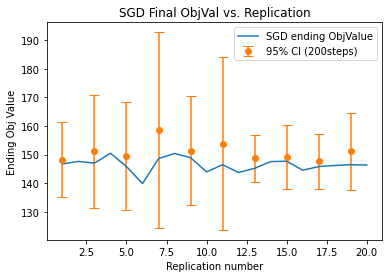

In [ ]:
plt.plot(NumReps, repObj,label='SGD ending ObjValue')
plt.errorbar(NumReps,muObj,yerr=errbar.T,capsize=5,errorevery=2,markevery=2,fmt='o',label='95% CI (200steps)')
plt.title('SGD Final ObjVal vs. Replication')
plt.xlabel('Replication number')
plt.ylabel('Ending Obj Value')
plt.legend();
print('Lower bound',np.mean(repObj))
print('Lower Bound Stdev',np.std(repObj))
print('Lower Bound Interval?', (np.mean(repObj)-1.96*np.std(repObj),np.mean(repObj)+1.96*np.std(repObj)))

In [ ]:
#Compute an Upper bound
#For each of the solutions found from each replication in the lower bound
#fix the decision at the optimal solution vector and solve as many times as needed to produce convergence
#in the objValMeans plot below, then record the objective value it converged to and the standard deviation of it.
#Once this is done for each of the solutions found from the lower bound replications, the minimum across replications
#will be the upper bound. 
objValMeans, objValues, ilist = [],[],[]
objSE,objMus= [],[]
s_opt = np.round(s_list[-1]) #fix the optimal solution at the last one
replications = 100
numsolves = 1 #does this need to be same as number of SGD steps? No.
nsolvs = []
for i in range(0,replications,5):
  for j in range(0,numsolves):
      #simulate a demand vector
      demand = simulateDemand()
      #solve the 2nd stage minimization problem given demand and last order-up-to vector
      b = solveModel(demand, s_opt)
      objValues.append(b.OBJ())
  objMeans = np.mean(objValues) 
  objMus.append(objMeans)
  objSE.append(np.std(objValues)/np.sqrt(numsolves))
  objValMeans.append(objMeans) 
  numsolves+=5
  nsolvs.append(numsolves)
  #dem.append(demand)
  ilist.append(i+1)

last obj value given optimal s: 145.16082474226803
CI: 132.05214238217212 146.5909036461366


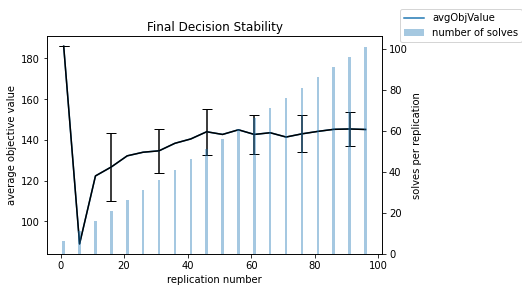

In [ ]:
fig,ax = plt.subplots()
ax.plot(ilist,objValMeans,label='avgObjValue')#,marker='.')
ax.set_xlabel('replication number')
ax.set_ylabel('average objective value')
ax.errorbar(ilist, objMus, yerr= objSE,capsize=5,color='k',errorevery=3)
ax2 = ax.twinx()
ax2.bar(ilist,nsolvs,label='number of solves',alpha=0.4)
ax2.set_ylabel('solves per replication')
ax.set_title('Final Decision Stability');
fig.legend(bbox_to_anchor=(1.22,1));
print('last obj value given optimal s:', objValMeans[-1])
print('CI:', (np.mean(objValMeans) - 1.96*np.std(objValMeans)/np.sqrt(len(ilist))), np.mean(objValMeans) + 1.96*np.std(objValMeans)/np.sqrt(len(ilist)))

last obj value given optimal s: 145.58928571428572


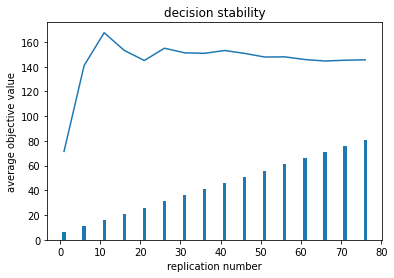

In [ ]:
plt.plot(ilist,objValMeans,label='avgObjVal')
plt.bar(ilist, nsolvs)
plt.title('decision stability')
plt.xlabel('replication number')
plt.ylabel('average objective value');
print('last obj value given optimal s:', objValMeans[-1])

In [ ]:
print('mean: ',np.mean(objValMeans))
print('CI:', (np.mean(objValMeans) - 1.96*np.std(objValMeans)/np.sqrt(len(objValMeans)), np.mean(objValMeans) + 1.96*np.std(objValMeans)/np.sqrt(len(objValMeans))))
#print('CI:', (np.mean(objValMeans) - 1.96*np.std(objValMeans), np.mean(objValMeans) + 1.96*np.std(objValMeans)))


mean:  144.75873499728607
CI: (135.05061312330272, 154.4668568712694)


In [ ]:
#print('Last Upper Bound',objValMeans[-1])
print('Upper Bound', np.mean(objValMeans))
print('Upper Bound std Dev', np.std(objValMeans))
print('Upper Bound Interval?', (np.mean(objValMeans) - np.std(objValMeans),np.mean(objValMeans) + np.std(objValMeans)))

Evaluate the SGD s-vector solution by studying stability of the objective value over multiple solves subject to random demand each solve.

In [ ]:
#miscellaneous
'''
plt.plot(ilist,objVals)
plt.title('Optimal Objective Value vs. Solves')
plt.xlabel('solve number')
plt.ylabel('Objective Value');
'''

"\nplt.plot(ilist,objVals)\nplt.title('Optimal Objective Value vs. Solves')\nplt.xlabel('solve number')\nplt.ylabel('Objective Value');\n"

In [ ]:
'''
print('"Upper Bound?", mean objective value over all solves using opt s-vector: \n',np.mean(objVals))
print('standard deviation of objective values over all solves s-vector: \n', np.std(objVals))

"Upper Bound?", mean objective value over all solves using opt s-vector: 
 74.521375
standard deviation of objective values over all solves s-vector: 
 42.03208572756502


### Extensions: Momentum & SGVD, etc.

In [ ]:
#Momentum variant of SGD uses running average of previous subgradients before updating the step.

In [ ]:
#SGVD is a variant of SGD that uses an online learning method by increasing the sample size (i.e. batch size) 
#after every step of SGD.

In [ ]:
#Other extensions to try: 
#adjust number of steps, batchsize and observe the convergence rates, solution stability
#Change the stepsize constant or stepsize divisor
#Change the number of point discretizations used for the demand vectors and its effect on convergence rate/solution stability

In [ ]:
def SGD_loop(s_vector,alpha_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      s_vector = s_vector - (alpha_k/np.sqrt(j+1))*subgstep

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist, runningObj

In [ ]:
#alpha_k = 1.0 #stepsize constant
#steps = 100
#batchsize= 10 
'''
subgsteps,subgnorms,dlist, s_list,steplist = SGD_loop(s_feas,1.0,100,10)
'''

'\nsubgsteps,subgnorms,dlist, s_list,steplist = SGD_loop(s_feas,1.0,100,10)\n'

In [ ]:
#Use plot to verify the SGD Convergence by checking that L2 Norm -> 0.
'''
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))
'''

"\nplt.plot(steplist,subgnorms)\nplt.xlabel('steps')\nplt.ylabel('L2 norm')\nplt.title('Subgradient Norm vs. Steps');\nprint('final subgradient norm: ',subgnorms[-1])\nprint('minimum subgradient is: ',np.min(subgnorms))\nprint('min subgradient occurs at step', np.argmin(subgnorms))\n"

adjust batchsize

In [ ]:
subgsteps_b ,subgnorms_b ,dlist_b , s_list_b ,steplist_b ,objlist_b = [],[],[],[],[],[]

batchsize_list = [10,25,50]
for i in batchsize_list:
  subgsteps,subgnorms,dlist, s_list,steplist,objlist = SGD_loop(s_feas,1.0,200,i,0)
  subgsteps_b.append(subgsteps)
  subgnorms_b.append(subgnorms)
  dlist_b.append(dlist)
  s_list_b.append(s_list)
  steplist_b.append(steplist)
  objlist_b.append(objlist)

In [ ]:
'''
#Use plot to verify the SGD Convergence by checking that L2 Norm -> 0.
steplist = steplist_b[0]
subgnorms = subgnorms_b[0]
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))
'''

Collapse all 3 graphs into a single graph with 3 colors

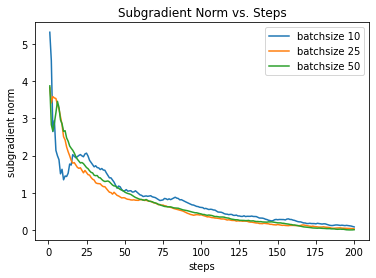

In [ ]:
#figure, axs = plt.subplots(1,3,figsize=(18,4))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(batchsize_list)):
#  steplist = steplist_b[i]
#  subgnorms = subgnorms_b[i]
  plt.plot(steplist,subgnorms_b[i],label = 'batchsize %i' %batchsize_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('subgradient norm')
plt.title('Subgradient Norm vs. Steps');
#  axs[i].plot(steplist,subgnorms)
#  axs[i].set_xlabel('steps')
#  axs[i].set_ylabel('subgradient norm')
#  axs[i].set_title('Subgradient Norm vs. Steps (batchsize %i)' %batchsize_list[i])
#print(subgnorms_b[-1])

In [ ]:
for i in range(len(batchsize_list)):
  print('final subgrad norm for batch %i' %batchsize_list[i]+': ', subgnorms_b[i][-1])

final subgrad norm for batch 10:  0.083916625289629
final subgrad norm for batch 25:  0.029680970334542634
final subgrad norm for batch 50:  0.009560596215717929


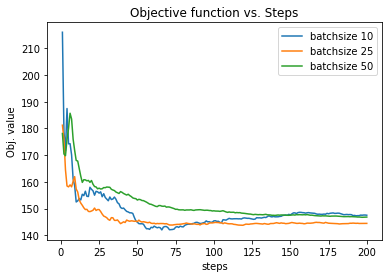

In [ ]:
#figure, axs = plt.subplots(1,3,figsize=(18,4))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(batchsize_list)):
    plt.plot(steplist,objlist_b[i],label = 'batchsize %i' %batchsize_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('Obj. value')
plt.title('Objective function vs. Steps');

  #steplist = steplist_b[i]
  #objlists = objlist_b[i]
  #axs[i].plot(steplist,objlists)
  #axs[i].set_xlabel('steps')
  #axs[i].set_ylabel('Objective Value')
  #axs[i].set_title('Objective function vs. Steps (batchsize %i)' %batchsize_list[i])
#np.asarray(objlists_b)[:,-1]

In [ ]:
for i in range(len(batchsize_list)):
  print('final obj for batchsize %i' %batchsize_list[i]+': ', objlist_b[i][-1])

final obj for batchsize 10:  147.51700082107465
final obj for batchsize 25:  144.4613068755067
final obj for batchsize 50:  146.828012433053


adjust learning rate

In [ ]:
subgsteps_b ,subgnorms_b ,dlist_b , s_list_b ,steplist_b ,objlist_b = [],[],[],[],[],[]

alpha_list = [0.5,1.0,2.0]
for i in alpha_list:
  subgsteps,subgnorms,dlist, s_list,steplist,objlist = SGD_loop(s_feas,i,200,25,0)
  subgsteps_b.append(subgsteps)
  subgnorms_b.append(subgnorms)
  dlist_b.append(dlist)
  s_list_b.append(s_list)
  steplist_b.append(steplist)
  objlist_b.append(objlist)

In [ ]:
alpha_list

[0.5, 1.0, 2.0]

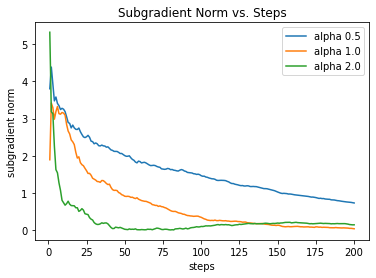

In [ ]:
#figure, axs = plt.subplots(1,3,figsize=(18,4))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(alpha_list)):
    plt.plot(steplist,subgnorms_b[i],label = 'alpha %.1f' %alpha_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('subgradient norm')
plt.title('Subgradient Norm vs. Steps');

#  steplist = steplist_b[i]
#  subgnorms = subgnorms_b[i]
#  axs[i].plot(steplist,subgnorms)
#  axs[i].set_ylabel('subgradient norm')
#  axs[i].set_xlabel('steps')
#  axs[i].set_title('Subgradient Norm vs. (learning rate %f)' %alpha_list[i])
#  print(subgnorms_b[i])
#print(len(alpha_list))

In [ ]:
for i in range(len(alpha_list)):
  print('final subgrad norm for alpha %1f' %alpha_list[i]+': ', subgnorms_b[i][-1])

final subgrad norm for alpha 0.500000:  0.7332222514354021
final subgrad norm for alpha 1.000000:  0.041013534351479634
final subgrad norm for alpha 2.000000:  0.14701969255851408


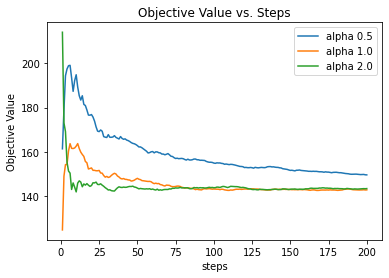

In [ ]:
#figure, axs = plt.subplots(1,3,figsize=(18,4))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(alpha_list)):
      plt.plot(steplist,objlist_b[i],label = 'alpha %.1f' %alpha_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('Objective Value')
plt.title('Objective Value vs. Steps');

#  steplist = steplist_b[i]
#  subgnorms = objlist_b[i]
#  axs[i].plot(steplist,subgnorms)
#  axs[i].set_ylabel('objective value')
#  axs[i].set_xlabel('steps')
#  axs[i].set_title('objective value vs. (learning rate %f)' %alpha_list[i])

In [ ]:
for i in range(len(alpha_list)):
  print('final subgrad norm for alpha %1f' %alpha_list[i]+': ', objlist_b[i][-1])

final subgrad norm for alpha 0.500000:  149.63560675578123
final subgrad norm for alpha 1.000000:  142.86323154467397
final subgrad norm for alpha 2.000000:  143.4497640609411


In [ ]:
np.asarray(objlist_b)[:,-1]

array([192.46642891, 183.40544818, 181.29265074])

SGD-momentum extension

In [ ]:
def Momentum_loop(s_vector,velocity_vector,alpha_k,beta_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      #velocity_vector = velocity_vector * beta_k - (alpha_k/np.sqrt(j+1))*subgstep  
      #for i in range(0,len(velocity_vector)):
      #  if velocity_vector[i] < 0:
      #    velocity_vector[i] = 0
      #  else:
      #    velocity_vector[i] = velocity_vector[i]
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      # velocity = momentun coef. (momentun) * old velocity - learning rate * old s
      # s = old s + velocity
      
      velocity_vector = velocity_vector * beta_k - (alpha_k/np.sqrt(j+1))*subgstep
      s_vector = s_vector + velocity_vector

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objlist = Momentum_loop(s_feas,ini_velocity,1.0,0.9,200,10)

  Signal handler called from  /usr/lib/python3.7/subprocess.py _execute_child 1505
  Waiting...
  Signal 2 recieved, but no process queued
  Exiting now


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


final subgradient norm:  0.7696355874698103
minimum subgradient is:  0.058110382970658014
min subgradient occurs at step 84


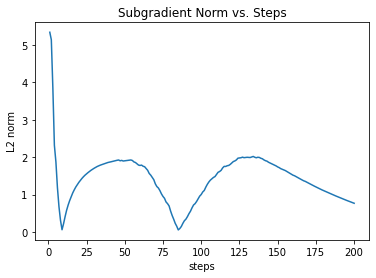

In [ ]:
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final subgradient norm:  0.7696355874698103
minimum subgradient is:  173.30217553905777
min subgradient occurs at step 5


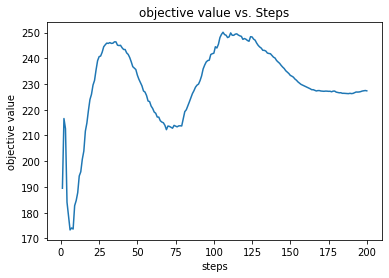

In [ ]:
plt.plot(steplist,objlist)
plt.xlabel('steps')
plt.ylabel('objective value')
plt.title('objective value vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(objlist))
print('min subgradient occurs at step', np.argmin(objlist))

In [ ]:
subgsteps_b ,subgnorms_b ,dlist_b , s_list_b ,steplist_b,objectlist_b = [],[],[],[],[],[]
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0]) 

beta_list = [0.1,0.5,0.9]
for i in beta_list:
  subgsteps,subgnorms,dlist, s_list,steplist,objectlist = Momentum_loop(s_feas,ini_velocity,1.0,i,200,10,0)
  subgsteps_b.append(subgsteps)
  subgnorms_b.append(subgnorms)
  dlist_b.append(dlist)
  s_list_b.append(s_list)
  steplist_b.append(steplist)
  objectlist_b.append(objectlist)

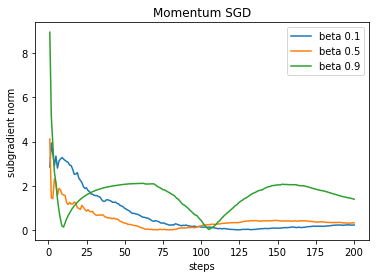

In [ ]:
#figure, axs = plt.subplots(1,3,figsize=(18,4))
#plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(beta_list)):
  plt.plot(steplist,subgnorms_b[i],label = 'beta %.1f' %beta_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('subgradient norm')
plt.title('Momentum SGD');

  #steplist = steplist_b[i]
  #subgnorms = subgnorms_b[i]
  #axs[i].plot(steplist,subgnorms)
  #axs[i].set_ylabel('subgradient norm')
  #axs[i].set_xlabel('steps')
  #axs[i].set_title('Subgradient Norm vs. (momentum coef %f)' %beta_list[i])

In [ ]:
for i in range(len(beta_list)):
  print('final subgrad norm for beta %1f' %beta_list[i]+': ', subgnorms_b[i][-1])

final subgrad norm for beta 0.100000:  0.24070781042583558
final subgrad norm for beta 0.500000:  0.3359274475240152
final subgrad norm for beta 0.900000:  1.4031934782844453


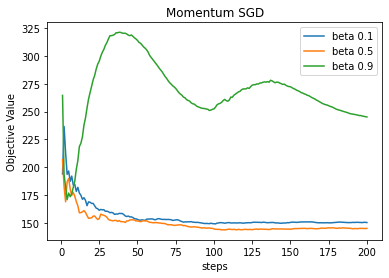

In [ ]:
for i in range(len(beta_list)):
  plt.plot(steplist,objectlist_b[i],label = 'beta %.1f' %beta_list[i])
plt.legend()
plt.xlabel('steps')
plt.ylabel('Objective Value')
plt.title('Momentum SGD');

In [ ]:
for i in range(len(beta_list)):
  print('final obj value for beta %1f' %beta_list[i]+': ', objectlist_b[i][-1])

final obj value for beta 0.100000:  150.41448626526997
final obj value for beta 0.500000:  145.16680842863238
final obj value for beta 0.900000:  245.1442649178052


In [ ]:
def Momentum_loop_v2(s_vector,velocity_vector,alpha_k,beta_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      #s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      #for i in range(0,len(s_cand)):
      #  if s_cand[i] < 0:
      #    subgstep[i] = 0
      #  else:
      #    subgstep = subgstep

      #update s-vector
      # velocity = momentun coef. (momentun) * old velocity + learning rate * old s
      # s = old s + velocity
      
      velocity_vector = velocity_vector * beta_k - (alpha_k/np.sqrt(j+1))*subgstep
      s_vector = s_vector + velocity_vector

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

final subgradient norm:  1.0961517059695707
minimum subgradient is:  0.051269209628739924
min subgradient occurs at step 94


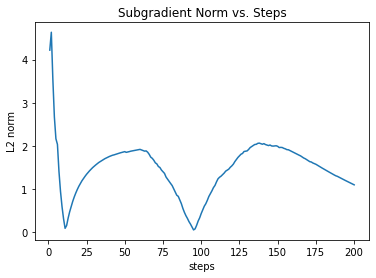

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = Momentum_loop_v2(s_feas,ini_velocity,1.0,0.9,200,10,0)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

In [ ]:
def Momentum_loop_v3(s_vector,velocity_vector,alpha_k,beta_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      # s = old s - momentun coef. (momentun) * old velocity - learning rate * old s
      s_vector = s_vector - velocity_vector * beta_k - (alpha_k/np.sqrt(j+1))*subgstep
      velocity_vector = velocity_vector 

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

final subgradient norm:  0.0630867458346046
minimum subgradient is:  0.011501579908623358
min subgradient occurs at step 184


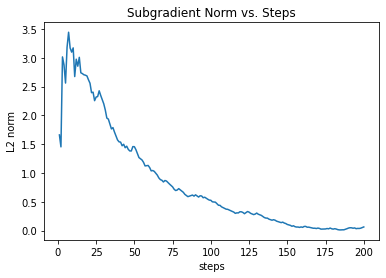

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = Momentum_loop_v3(s_feas,ini_velocity,1.0,0.5,200,10)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  145.3583450598488
minimum objective value is:  145.22731881940067
min objective value occurs at step 198


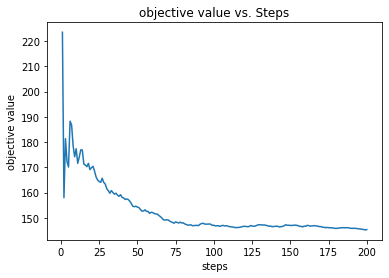

In [ ]:
plt.plot(steplist,objectlist)
plt.xlabel('steps')
plt.ylabel('objective value')
plt.title('objective value vs. Steps');
print('final objective value: ',objectlist[-1])
print('minimum objective value is: ',np.min(objectlist))
print('min objective value occurs at step', np.argmin(objectlist))

In [ ]:
def Momentum_loop_v4(s_vector,velocity_vector,alpha_k,beta_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []
  print(IntDemandType)

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      # s = old s - momentun coef. (momentun) * old velocity - learning rate * old s
      velocity_vector = velocity_vector * beta_k + (alpha_k/np.sqrt(j+1))*subgstep
      s_vector = s_vector - velocity_vector - (alpha_k/np.sqrt(j+1))*subgstep

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

0
final subgradient norm:  0.5536436128052052
minimum subgradient is:  0.060631442956604616
min subgradient occurs at step 79


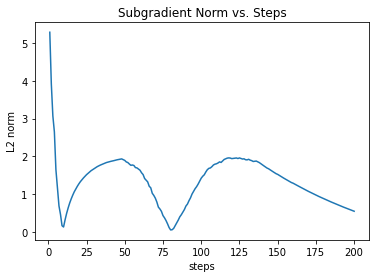

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = Momentum_loop_v4(s_feas,ini_velocity,1.0,0.9,200,10)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

adagradient

In [ ]:
def Adagradient_loop(s_vector,velocity_vector,alpha_k,epsilon_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      # st = old st + grad**2
      # s = old s - grad * learning rate / sqrt(st + epsilon)
      
      velocity_vector = velocity_vector + subgstep * subgstep
      s_vector = s_vector - subgstep * alpha_k / np.sqrt( velocity_vector + epsilon_k )

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

final subgradient norm:  0.07794228634059948
minimum subgradient is:  0.007655473182624872
min subgradient occurs at step 180


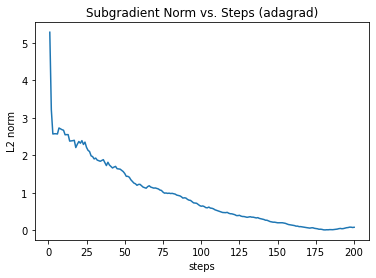

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnormsa,dlist,s_list,steplist ,objectlista = Adagradient_loop(s_feas,ini_velocity,1.0,0.0000001,200,10,0)

plt.plot(steplist,subgnormsa)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps (adagrad)');
print('final subgradient norm: ',subgnormsa[-1])
print('minimum subgradient is: ',np.min(subgnormsa))
print('min subgradient occurs at step', np.argmin(subgnormsa))

final objective value:  146.62941375905194
minimum objective value is:  142.5
min objective value occurs at step 0


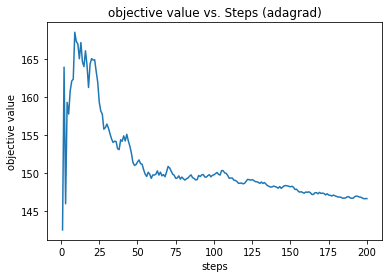

In [ ]:
plt.plot(steplist,objectlista)
plt.xlabel('steps')
plt.ylabel('objective value')
plt.title('objective value vs. Steps (adagrad)');
print('final objective value: ',objectlista[-1])
print('minimum objective value is: ',np.min(objectlista))
print('min objective value occurs at step', np.argmin(objectlista))

In [ ]:
'''
subgsteps_b ,subgnorms_b ,dlist_b , s_list_b ,steplist_b = [],[],[],[],[]
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

epsilon_list = [0.0000001,0.000001,0.00001]
for i in epsilon_list:
  subgsteps,subgnorms,dlist, s_list,steplist = Adagradient_loop(s_feas,ini_velocity,1.0,i,100,10)
  subgsteps_b.append(subgsteps)
  subgnorms_b.append(subgnorms)
  dlist_b.append(dlist)
  s_list_b.append(s_list)
  steplist_b.append(steplist)
'''

In [ ]:
'''
figure, axs = plt.subplots(1,3,figsize=(18,4))
plt.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(len(epsilon_list)):
  steplist = steplist_b[i]
  subgnorms = subgnorms_b[i]
  axs[i].plot(steplist,subgnorms)
  axs[i].set_title('Subgradient Norm vs. epsilon %f' %epsilon_list[i])
'''

RMSprop

In [ ]:
def RMSprop_loop(s_vector,velocity_vector,alpha_k,beta_k,epsilon_k,stepsize,batchsize,IntDemandType = 0):
  subglist,steplist,subgsteps,subgnorms,batchglist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
  runningObj = []

  for j in range(0,stepsize): #try error tolerance subgradnorm < 0.01 while loop instead of steps
      for i in range(0,batchsize):
          #simulate a demand vector
          if IntDemandType == 0:
              demand = simulateDemand()
          else: 
              demand = simulateDemand2()
          #solve the 2nd stage minimization problem given demand and last order-up-to vector
          a = solveModel(demand,s_vector)
          #compute subgradient from duals
          subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
                 a.dual[a.Constraint2] + a.dual[a.Constraint17],\
                 a.dual[a.Constraint3] + a.dual[a.Constraint18],\
                 a.dual[a.Constraint4] + a.dual[a.Constraint19],\
                 a.dual[a.Constraint5] + a.dual[a.Constraint20],\
                 a.dual[a.Constraint6] + a.dual[a.Constraint21],\
                 a.dual[a.Constraint7] + a.dual[a.Constraint22]])
          objlist.append(a.OBJ())
          subglist.append(subgrad)
          batchdem.append(demand)
      batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
      subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
      objavg = np.mean(objlist)
      runningObj.append(objavg)

      #projection step
      s_cand = s_vector - (alpha_k/np.sqrt(j+1))*subgstep
      for i in range(0,len(s_cand)):
        if s_cand[i] < 0:
          subgstep[i] = 0
        else:
          subgstep = subgstep

      #update s-vector
      # st = beta * old st + (1-beta) * grad**2
      # s = old s - grad * learning rate / sqrt(st + epsilon)
      
      velocity_vector = beta_k * velocity_vector + ( 1 - beta_k ) * subgstep * subgstep
      s_vector = s_vector - subgstep * alpha_k / np.sqrt( velocity_vector + epsilon_k )

      #record history
      err_step = np.linalg.norm(subgstep)
      subgsteps.append(subgstep)
      subgnorms.append(err_step)
      batchglist.append(batchgdem)
      s_list.append(s_vector)
      steplist.append(j+1)
  return subgsteps, subgnorms, batchglist, s_list, steplist,runningObj

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = RMSprop_loop(s_feas,ini_velocity,1.0,0.9,0.0000001,200,10)

final subgradient norm:  0.008066132902450838
minimum subgradient is:  0.008066132902450838
min subgradient occurs at step 199


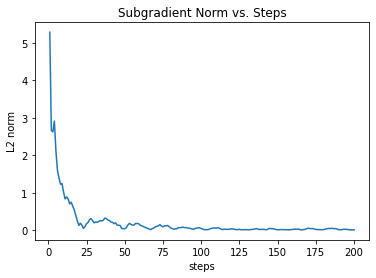

In [ ]:
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  148.49079500714095
minimum objective value is:  147.00779280970318
min objective value occurs at step 81


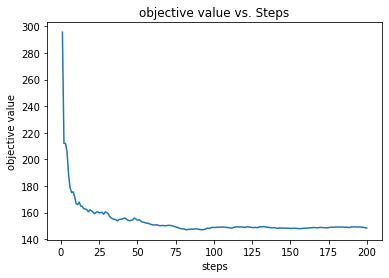

In [ ]:
plt.plot(steplist,objectlist)
plt.xlabel('steps')
plt.ylabel('objective value')
plt.title('objective value vs. Steps');
print('final objective value: ',objectlist[-1])
print('minimum objective value is: ',np.min(objectlist))
print('min objective value occurs at step', np.argmin(objectlist))

final subgradient norm rms:  0.008066132902450838
final subgradient norm adagrad:  0.07794228634059948


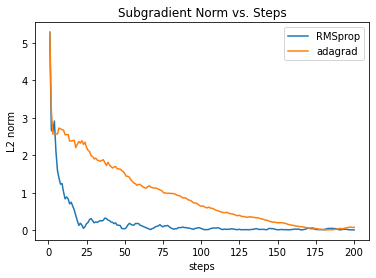

In [ ]:
#Compare RMS to adagrad
plt.plot(steplist,subgnorms,label='RMSprop')
plt.plot(steplist,subgnormsa,label='adagrad')
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.legend()
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm rms: ',subgnorms[-1])
print('final subgradient norm adagrad: ',subgnormsa[-1])
#print('minimum subgradient is: ',np.min(subgnorms))
#print('min subgradient occurs at step', np.argmin(subgnorms))

final obj. rms:  148.49079500714095
final obj. adagrad:  146.62941375905194


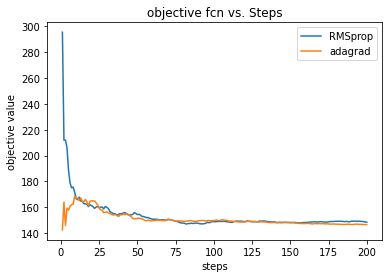

In [ ]:
plt.plot(steplist,objectlist,label='RMSprop')
plt.plot(steplist,objectlista,label='adagrad')
plt.xlabel('steps')
plt.ylabel('objective value')
plt.legend()
plt.title('objective fcn vs. Steps');
print('final obj. rms: ',objectlist[-1])
print('final obj. adagrad: ',objectlista[-1])
#print('minimum subgradient is: ',np.min(subgnorms))
#print('min subgradient occurs at step', np.argmin(subgnorms))

### Extension 2: Correlated Demand via Grid Gibbs Sampling<br>

Consider the situation in which demands may be correlated between two or more retailers. In this situation, we imagine that two retailers may be geographically close so that their demands are negatively correlated with one another. Suppose that after observing past data we have estimates of how the demands at two of such retailers are correlated. In such a situation, we effectively sample from the joint bivariate normal distribution of the two retailers and treat the remaining 5 retailers as independent. For pedagogical and illustrative reasons, we deal only with the case for two correlated retailer demands, but this approach can be generalized to higher dimensional joint distributions.

The gibbs sampler MCMC algorithm is a common algorithm used to sample from computationally difficult or unknown joint distributions. However, due to the fact that most samplers rely on simulations of a continuous random variable, directly sampling from in-built distributions can lead to a blow up in the number of scenarios that our SLP optimizes over and cause failures in convergence for stochastic algorithms such as SGD. Consequently, in using Gibbs sampling we sample from the discretized analogues of the conditional distributions and investigate the impact that correlations in demand may have upon the behavior of our SGD algorithm's optimization. 

In [ ]:
mus = np.array([100,200])
cov = -30.0
cov_mat = np.asarray([[20,cov],[cov,50]])

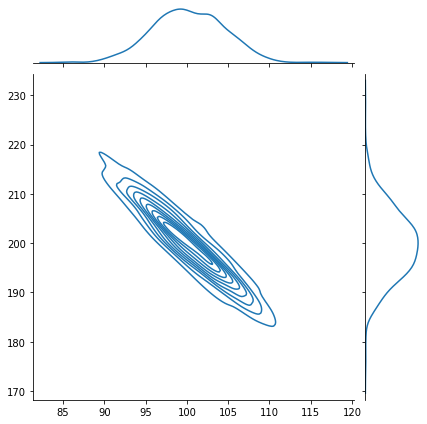

In [ ]:
#Visualize direct sampling from bivariate normal
samples = np.random.multivariate_normal(mus,cov_mat,1000)
sns.jointplot(x=samples[:,0],y=samples[:,1],kind='kde')#,alpha = 0.7)
#g.plot_joint(sns.kdeplot,color='r',levels=4,zorder=1)
#plt.title('Level Sets from Multivariate Normal')
#plt.xlabel('\mu_1')
#plt.ylabel('\mu_2')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


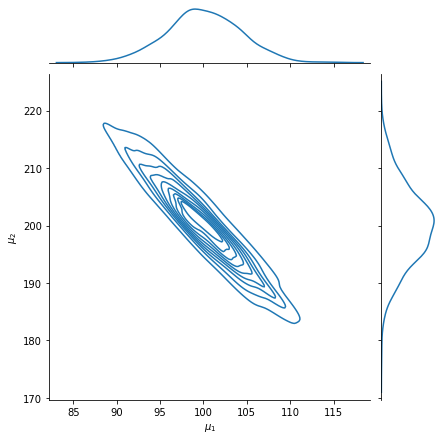

In [ ]:
## Direct sampling from bivariate normal
samples = np.random.multivariate_normal(mus, cov_mat, 1000)
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')
g.set_axis_labels('$\mu_1$','$\mu_2$',fontsize=10)
plt.show()

In [ ]:
cov_mat

array([[ 20., -50.],
       [-50.,  50.]])

In [ ]:
def x_cond_y(y,mus,cov_mat,n_pts,res):
#  mu = mus[0]+cov_mat[1,0]/cov_mat[0,0] * (y - mus[1])
#  sigma = cov_mat[0,0] - cov_mat[1,0]/cov_mat[1,1]*cov_mat[1,0]
  mu = mus[0] + cov_mat[0,1]/cov_mat[1,1]*(y-mus[1])
  sigma = cov_mat[0,0]-(cov_mat[0,1]**2)/cov_mat[1,1]
  val, wts = discretizeNormal(mu,sigma,n_pts,res)
  return random.choices(val,weights=wts).pop()

def y_cond_x(x,mus,cov_mat,n_pts,res):
#  mu = mus[1]+cov_mat[0,1]/cov_mat[1,1]*(x - mus[0])
#  sigma = cov_mat[1,1]-cov_mat[0,1]/cov_mat[0,0] *cov_mat[0,1]
  mu = mus[1]+cov_mat[0,1]/cov_mat[0,0]*(x-mus[0])
  sigma = cov_mat[1,1]-(cov_mat[0,1]**2)/cov_mat[0,0]
  val, wts = discretizeNormal(mu,sigma,n_pts,res)
  return random.choices(val,weights=wts).pop()

def gibbs_dsampler(mus,cov_mat,n_pts,n_steps=2000,res=0.5):
  samples=[]
  y = mus[1]
  for _ in range(n_steps):
    x = x_cond_y(y,mus,cov_mat,n_pts,res)
    y = y_cond_x(x,mus,cov_mat,n_pts,res)
    samples.append([x,y])
  return samples

In [ ]:
#discrete gibbs sampler
#get 1500 samples, do visualization and tuning to find a good res value and n_pts
#n_pts = 7 and res = 0.1 provides a relatively high-res approximation for the joint, but slow 
#n_pts = 5 and res = 0.5 also is viable hyperparam for gibbs. #total discrete values = n_pts/res
dsamples = gibbs_dsampler(mus,cov_mat,n_pts= 5,n_steps=5000,res=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


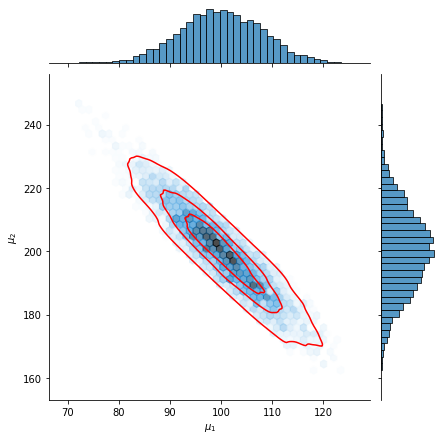

In [ ]:
#visualize samples from the discrete gibbs sampler
burnin = 500
x, y = zip(*dsamples[burnin:])
g=sns.jointplot(x, y, kind='hex',alpha=0.7)
g.plot_joint(sns.kdeplot,color='r',zorder=1,levels=4)
g.set_axis_labels('$\mu_1$','$\mu_2$',fontsize=10)
plt.show()

In [ ]:
dsamples = dsamples[burnin:]

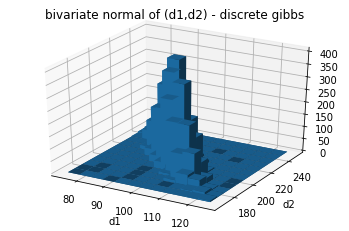

In [ ]:
#3d histogram density plot of the discrete gibbs
xAmplitudes = np.squeeze(np.asarray(dsamples)[burnin:,0])
yAmplitudes = np.squeeze(np.asarray(dsamples)[burnin:,1])

x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
y = np.array(yAmplitudes)

fig = plt.figure()          # matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram set bins
hist, xedges, yedges = np.histogram2d(x, y, bins=(12,12))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

max_height = np.max(dz)   # get range for normalizing normalize
min_height = np.min(dz)

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')#color=rgba, zsort='average')
plt.title("bivariate normal of (d1,d2) - discrete gibbs")
plt.xlabel("d1")
plt.ylabel("d2")
#plt.zlabel('freq')
#plt.savefig("bivariate normal of (d1,d2)")
plt.show()

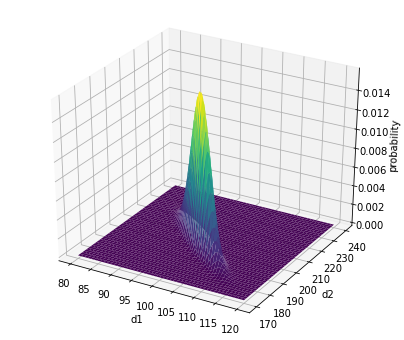

In [ ]:
from scipy.stats import multivariate_normal
#plot true bivariate normal for d1, d2
#Parameters
mu_x = mus[0]
variance_x = cov_mat[0,0]

mu_y = mus[1]
variance_y = cov_mat[1,1]

#Create meshgrid and multivariate normal
x = np.linspace(80,120,500)
y = np.linspace(170,240,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv = multivariate_normal([mu_x, mu_y], [[variance_x, cov], [cov, variance_y]])

#Make a 3D plot
fig = plt.figure(figsize=(7,6))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=10)
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('probability')
plt.show()

In [ ]:
test_vals,test_wts = discretizeNormal(200,50,5,res=0.5)
#test_vals2,test_wts2 = discretizeNormal(100,20,5,res=0.5)
#test_vals3,test_wts3 = discretizeNormal(170,50,5,res=0.5)

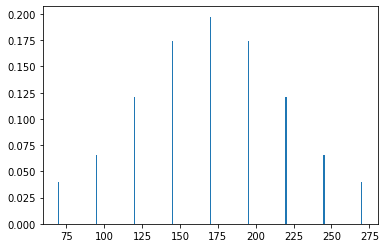

In [ ]:
#plt.bar(test_vals,test_wts);
#plt.bar(test_vals2,test_wts2);
#plt.bar(test_vals3,test_wts3);

In [ ]:
def simulateDemand2(n = 5):
    dsamples=gibbs_dsampler(mus,cov_mat,n_pts = n,n_steps=500,res=0.5)
    d1 = np.round(dsamples[-1][0])
    d2 = np.round(dsamples[-1][1])
#   d4 = np.round(dsamples[-1][0])
#   d7 = np.round(dsamples[-1][1])
#    Retailer1_values, Retailer1_weights = discretizeNormal(100,20,n)
#    d1 = np.asarray(random.choices(Retailer1_values, weights = Retailer1_weights)).item()
#    Retailer2_values, Retailer2_weights = discretizeNormal(200,50,n)
#    d2 = np.asarray(random.choices(Retailer2_values, weights = Retailer2_weights)).item()
    Retailer3_values, Retailer3_weights = discretizeNormal(150,30,n)
    d3 = np.asarray(random.choices(Retailer3_values, weights = Retailer3_weights)).item()
    Retailer4_values, Retailer4_weights = discretizeNormal(170,50,n)
    d4 = np.asarray(random.choices(Retailer4_values, weights = Retailer4_weights)).item()
    Retailer5_values, Retailer5_weights = discretizeNormal(180,40,n)
    d5 = np.asarray(random.choices(Retailer5_values, weights = Retailer5_weights)).item()
    Retailer6_values, Retailer6_weights = discretizeNormal(170,30,n)
    d6 = np.asarray(random.choices(Retailer6_values, weights = Retailer6_weights)).item()
    Retailer7_values, Retailer7_weights = discretizeNormal(170,50,n)
    d7 = np.asarray(random.choices(Retailer7_values, weights = Retailer7_weights)).item()
    d = [d1,d2,d3,d4,d5,d6,d7]
    return d

In [ ]:
demand2 = simulateDemand2()
demand2

[88.0, 216.0, 120, 120, 100, 170, 120]

In [ ]:
s_feas =[]
for i in m1.s.extract_values():
    s_feas.append(m1.s.extract_values()[i])
s_feas

[100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]

In [ ]:
#SGD with for loop
s_old = s_feas
subglist,steplist,subgsteps,subgnorms,dlist, batchdem, s_list,objlist = [],[],[],[],[],[],[],[]
runningObj = []
alpha_k = 1.0 #stepsize constant
steps = 100
batchsize= 5 #number of solves per step

for j in range(0,steps): #try error tolerance subgradnorm < 0.01 while loop instead of steps
    for i in range(0,batchsize):
        #simulate a demand vector
        demand2 = simulateDemand2()
        #solve the 2nd stage minimization problem given demand and last order-up-to vector
        a = solveModel(demand2,s_old)
        #compute subgradient from duals
        subgrad = np.asarray([a.dual[a.Constraint1] + a.dual[a.Constraint16],\
               a.dual[a.Constraint2] + a.dual[a.Constraint17],\
               a.dual[a.Constraint3] + a.dual[a.Constraint18],\
               a.dual[a.Constraint4] + a.dual[a.Constraint19],\
               a.dual[a.Constraint5] + a.dual[a.Constraint20],\
               a.dual[a.Constraint6] + a.dual[a.Constraint21],\
               a.dual[a.Constraint7] + a.dual[a.Constraint22]])
        objlist.append(a.OBJ())
        subglist.append(subgrad)
        batchdem.append(demand2)
    batchgdem = np.mean(batchdem,axis=0) #average sim demand across all solves in the batchsize
    subgstep = np.mean(subglist,axis=0) #average subgradients across all solves in the batchsize
    objavg = np.mean(objlist)
    runningObj.append(objavg)
    
    #projection step
    s_cand = s_old - (alpha_k/np.sqrt(j+1))*subgstep
    for i in range(0,len(s_cand)):
      if s_cand[i] < 0:
        subgstep[i] = 0
      else:
        subgstep = subgstep
    
    #update s-vector
    s_old = s_old - (alpha_k/np.sqrt(j+1))*subgstep #divide by current step or sqrt of current step
    #try different divisors or different step size constants
    
    #record history
    err = np.linalg.norm(subgstep)
    subgsteps.append(subgstep)
    subgnorms.append(err)
    dlist.append(batchgdem)
    s_list.append(s_old)
    steplist.append(j+1)

In [ ]:
#means of demand vector
print('true means of demand: ',[100.,200.,150.,170.0, 180.0, 170.0, 170.0])
print('running average demand: \n', np.mean(dlist,axis=0).tolist())
print('last demand: \n', dlist[-1].tolist())
print('last s-vector: \n', s_list[-1].tolist())
print('last avg subgradient: \n', subgsteps[-1].tolist())

true means of demand:  [100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]
running average demand: 
 [100.38788575300845, 199.24590525777643, 150.05855763870946, 168.23443463233772, 177.3881200524946, 168.70493908140608, 176.68327501619126]
last demand: 
 [100.394, 199.662, 150.3, 166.0, 177.92, 170.18, 174.4]
last s-vector: 
 [111.32320736076409, 211.70332374212347, 162.35229889830117, 181.8670346523599, 191.93427024498774, 180.9819706266918, 182.32982477715842]
last avg subgradient: 
 [-0.081, -0.129, -0.174, -0.134, -0.144, -0.159, -0.181]


final subgradient norm:  0.3875719288080601
minimum subgradient is:  0.3875719288080601
min subgradient occurs at step 99


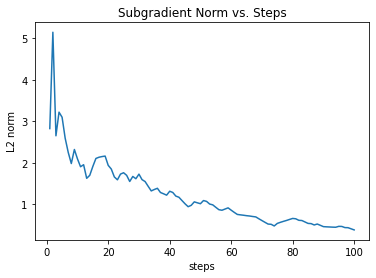

In [ ]:
#Use plot to verify the SGD Convergence by checking that L2 Norm -> 0.
plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  149.97818222839052


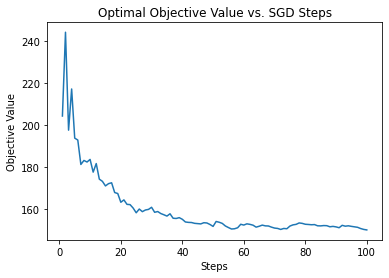

In [ ]:
plt.plot(steplist,runningObj)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', runningObj[-1])

In [ ]:
print('minimum subgradient: ',np.min(subgnorms))
print('step of min subgradient: ', np.argmin(subgnorms))

minimum subgradient:  0.3875719288080601
step of min subgradient:  99


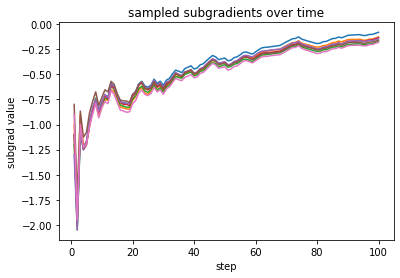

In [ ]:
plt.plot(steplist,subgsteps)
plt.title('sampled subgradients over time')
plt.ylabel('subgrad value')
plt.xlabel('step');

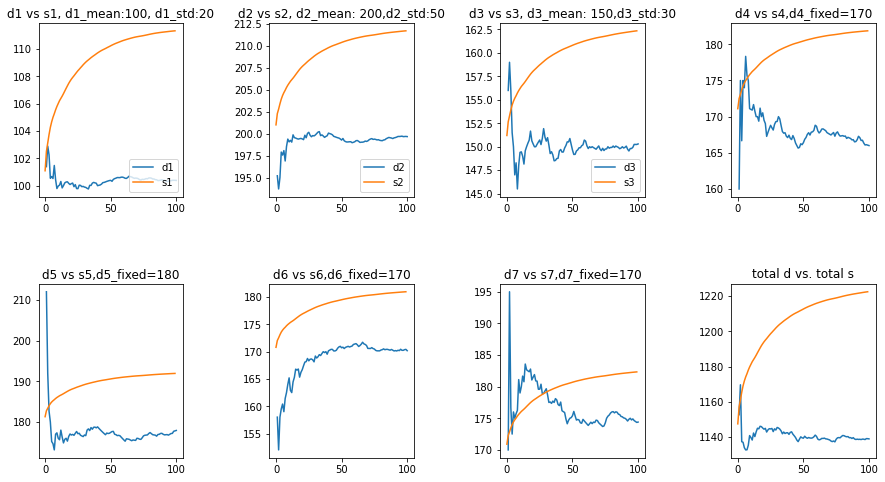

In [ ]:
s1,d1,s2,d2,s3,d3,s4,d4,s5,d5,s6,d6,s7,d7 = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i in range(0,len(s_list)):
    s1.append(s_list[i][0])
    d1.append(dlist[i][0])
    s2.append(s_list[i][1])
    d2.append(dlist[i][1])
    s3.append(s_list[i][2])
    d3.append(dlist[i][2])
    s4.append(s_list[i][3])
    d4.append(dlist[i][3])
    s5.append(s_list[i][4])
    d5.append(dlist[i][4])
    s6.append(s_list[i][5])
    d6.append(dlist[i][5])
    s7.append(s_list[i][6])
    d7.append(dlist[i][6])
s_tot,d_tot =[],[]
for j in range(0,len(s_list)):
  s_tot.append(np.sum(s_list[j]))
  d_tot.append(np.sum(dlist[j]))
figure, axs = plt.subplots(2,4,figsize=(15,8))
plt.subplots_adjust(hspace=0.5,wspace=0.6)
axs[0,0].plot(steplist,d1,s1)
axs[0,0].set_title('d1 vs s1, d1_mean:100, d1_std:20')
axs[0,0].legend(['d1','s1'],loc='lower right')
axs[0,1].plot(steplist,d2,s2)
axs[0,1].set_title('d2 vs s2, d2_mean: 200,d2_std:50')
axs[0,1].legend(['d2','s2'],loc='lower right')
axs[0,2].plot(steplist,d3,s3)
axs[0,2].set_title('d3 vs s3, d3_mean: 150,d3_std:30')
axs[0,2].legend(['d3','s3'],loc='lower right')
axs[0,3].plot(steplist,d4,s4)
axs[0,3].set_title('d4 vs s4,d4_fixed=170')
axs[1,0].plot(steplist,d5,s5)
axs[1,0].set_title('d5 vs s5,d5_fixed=180')
axs[1,1].plot(steplist,d6,s6)
axs[1,1].set_title('d6 vs s6,d6_fixed=170')
axs[1,2].plot(steplist,d7,s7)
axs[1,2].set_title('d7 vs s7,d7_fixed=170');
axs[1,3].plot(steplist,d_tot,s_tot)
axs[1,3].set_title('total d vs. total s');

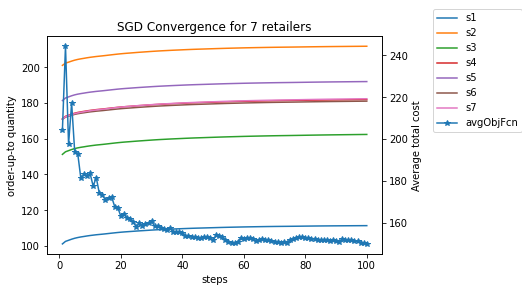

In [ ]:
fig,ax = plt.subplots()
ax.plot(steplist,s1,label='s1')#,marker='.')
ax.plot(steplist,s2,label='s2')# ,marker='v')
ax.plot(steplist,s3,label='s3')#,marker='^')
ax.plot(steplist,s4,label='s4')#,marker='s')
ax.plot(steplist,s5,label='s5')#,marker='p')
ax.plot(steplist,s6,label='s6')#,marker='P')
ax.plot(steplist,s7,label='s7')#,marker='*')
ax.set_xlabel('steps')
ax.set_ylabel('order-up-to quantity')
ax2 = ax.twinx()
ax2.plot(steplist,runningObj,label='avgObjFcn',marker='*')
ax2.set_ylabel('Average total cost')
ax.set_title('SGD Convergence for 7 retailers');
fig.legend(bbox_to_anchor=(1.22,1));

final subgradient norm:  0.7770185004232525
minimum subgradient is:  0.7770185004232525
min subgradient occurs at step 99


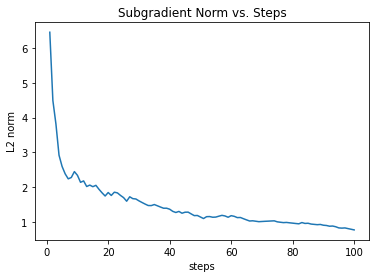

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = Momentum_loop_v3(s_feas,ini_velocity,1.0,0.9,100,10,1)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  187.10363632357092


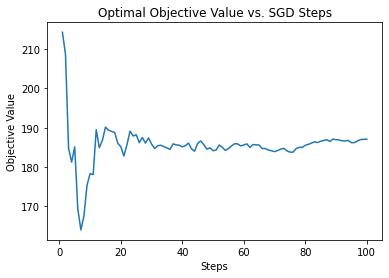

In [ ]:
plt.plot(steplist,objectlist)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', objectlist[-1])

final subgradient norm:  0.6238799964736809
minimum subgradient is:  0.40311288741492746
min subgradient occurs at step 1


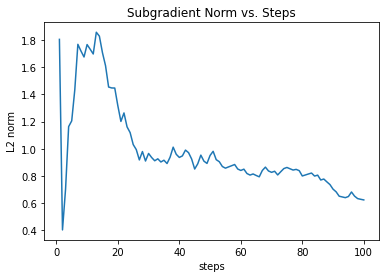

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist ,objectlist = Adagradient_loop(s_feas,ini_velocity,1.0,0.0000001,100,10,1)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  184.1287614735765


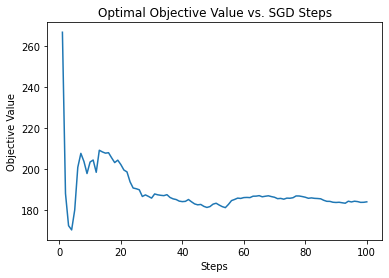

In [ ]:
plt.plot(steplist,objectlist)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', objectlist[-1])

final subgradient norm:  0.04217522969706271
minimum subgradient is:  0.04217522969706271
min subgradient occurs at step 99


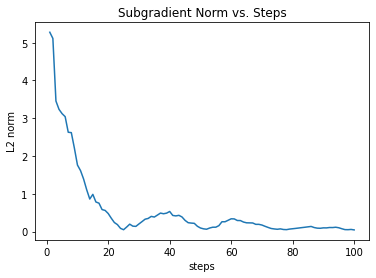

In [ ]:
ini_velocity = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

subgsteps,subgnorms,dlist, s_list,steplist,objectlist = RMSprop_loop(s_feas,ini_velocity,1.0,0.9,0.0000001,100,10,1)

plt.plot(steplist,subgnorms)
plt.xlabel('steps')
plt.ylabel('L2 norm')
plt.title('Subgradient Norm vs. Steps');
print('final subgradient norm: ',subgnorms[-1])
print('minimum subgradient is: ',np.min(subgnorms))
print('min subgradient occurs at step', np.argmin(subgnorms))

final objective value:  184.26050222070432


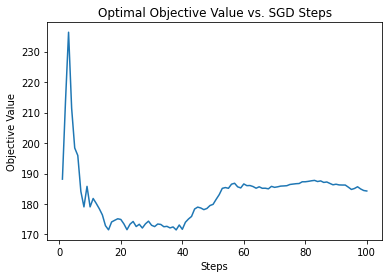

In [ ]:
plt.plot(steplist,objectlist)
plt.xlabel('Steps')
plt.ylabel('Objective Value')
plt.title('Optimal Objective Value vs. SGD Steps');
print('final objective value: ', objectlist[-1])